## Satellite Tracking
The recent privatization of space flight have led to the launch of thousands of artificial satellites. These satellites emit electromagnetic radiation across a wide variety of broad- and narrowband frequencies from both intentional and unintentional emissions ([Di Vruno et al. 2023](https://www.aanda.org/articles/aa/pdf/forth/aa46374-23.pdf)). These are begining to negatively impact all ground-based observing through tracks being left in optical images and false signals appearing in radio data.

In an attempt to keep track of satellite emissions, we are going to allocate 4 dishes at the Allen Telescope Array to collect emission data from the regions of the sky which are hte most affected. This will hopefully lead to an exhaustive list of frequencies and locations for all satellites in orbit.

The first step of this is to create a plot with the location of all active satellites in the sky above Hat Creek, the location of the Allen Telescope Array, throughout the course of one day. 

In [1]:
#Import everything you need
import numpy as np
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook 
from matplotlib.colors import LinearSegmentedColormap
from skyfield import almanac
from skyfield.api import load, wgs84
from skyfield.magnitudelib import planetary_magnitude
from skyfield.api import EarthSatellite
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
import matplotlib
#Makes plots interactive
%autosave 30 
#Makes it to where it autosaves every minute instead of every 2 minutes, just for peace of mind

Autosaving every 30 seconds


In [2]:
#Use skyfield to import the TLE (two-line element) file [gives you all the information on a satellite's location at 
#the epoch, which can be used to find its location at any time] for all active satellites on Norad
active_url = 'https://celestrak.org/norad/elements/active.txt'
active = load.tle_file(active_url, reload = True)
print('Loaded', len(active), 'satellites')

[#################################] 100% active.txt


Loaded 8364 satellites


In [3]:
#setting up the times to look at the satellites
ts = load.timescale()
t = []
today = ts.now().utc #It will look at the satellites on the day the notebook is run as default. This can be changed if necessary
for i in range(24):
    for j in range(0, 60, 10):
        t.append(ts.utc(today[0], today[1], today[2], i, j, 0))

In [4]:
observing_location= EarthLocation.of_site('ATA')#A different way to set our location
observing_time = []
for i in range(len(t)):
    observing_time.append(Time(t[i].utc_datetime()))
aa = AltAz(location=observing_location, obstime=observing_time)

In [5]:
ata = wgs84.latlon(+observing_location.lat.value, observing_location.lon.value)

In [6]:
names = []
for i in range(len(active)):
    names.append(active[i].name)

In [7]:
difference = []
for i in range(len(active)):
    difference.append(active[i] - ata)

In [8]:
topocentric = []
for i in range(len(difference)):
    for j in range(len(t)):
        topocentric.append(difference[i].at(t[j]))

In [9]:
%%time
#takes about 1 minute to run
alt = []
az = []
distance = []
for i in range(len(topocentric)):
    if np.isnan(topocentric[(i)].altaz()[0].degrees) == True:
        alt.append(0)
        az.append(0)
        distance.append(0)
    elif np.isnan(topocentric[(i)].altaz()[0].degrees) == False:
        alt.append(topocentric[i].altaz()[0].degrees)
        az.append(topocentric[i].altaz()[1].degrees)
        distance.append(topocentric[i].altaz()[2].au)

CPU times: user 1min 6s, sys: 628 ms, total: 1min 6s
Wall time: 1min 7s


In [10]:
alt = np.reshape(alt, (len(active), len(t)))
az = np.reshape(az, (len(active), len(t)))
distance = np.reshape(distance, (len(active), len(t)))

Splitting the satellites up into their orbital types

In [11]:
import urllib

In [12]:
data = urllib.request.urlopen('https://celestrak.org/norad/elements/active.txt').read()

In [13]:
%%time
#About 3 minutes to run
namess = []
for i in range(int(len(data.splitlines())/3)):
    #print(i) #Uncomment this out if you want to see how much it's run
    n = []
    for j in range(len(data.splitlines()[i*3])):
        n.append(data.splitlines()[i*3].decode()[-(j+1)])
    for j in range(len(n)):
        if n[j] != ' ':
            namess.append(data.splitlines()[i*3].decode()[:(len(n) - j)])
            break

CPU times: user 3min 24s, sys: 2.09 s, total: 3min 26s
Wall time: 3min 27s


In [14]:
%%time
from skyfield.api import EarthSatellite

ts = load.timescale()
satellites = []
line1 = []
line2 = []
for i in range(len(namess)):
    named = namess[i]
    line1.append(data.splitlines()[(i*3)+1].decode())
    line2.append(data.splitlines()[(i*3)+2].decode())
    satellites.append(EarthSatellite(line1[i], line2[i], named, ts))
#print(satellite

CPU times: user 16.1 s, sys: 1.23 s, total: 17.4 s
Wall time: 17.4 s


In [15]:
%%time
alt = np.reshape(alt, (len(active) * len(t)))
az = np.reshape(az, (len(active) * len(t)))
distance = np.reshape(distance, (len(active) * len(t)))


CPU times: user 24 µs, sys: 3 µs, total: 27 µs
Wall time: 26.9 µs


In [16]:
altaz = []
for i in range(len(alt)):
    altaz.append([alt[i], az[i]])

In [17]:
a = []
for i in range(len(line2)):
    a.append(float(line2[i][52:63]))

In [18]:
MEO = []
LEO = []
GEO = []
HEO = []
for i in range(len(line2)):
    if 0.9 <= float(line2[i][52:63]) <= 1.2:
        GEO.append(i)
    if float(line2[i][52:63]) < 0.9:
        HEO.append(i)
    if 1.2 < float(line2[i][52:63]) < 12:
        MEO.append(i)
    if 12 <= float(line2[i][52:63]):
        LEO.append(i)

Frequency scraping

In [19]:
import csv
name = []
freq = []
bandwidth = []
id_sc = []
with open('../SatList.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        name.append(row['Name'])
        freq.append(row['Frequency [MHz]'])
        bandwidth.append(row['Bandwidth [kHz]/Baud'])
        id_sc.append(row["ID"])

In [20]:
name_s = []
freq_s = []
bandwidth_s = []
id_s = []
n = []
h = []
for i in range(len(line2)):
    for j in range(len(id_sc)):
        try:
            if int(line2[i][2:7]) == int(id_sc[j]):
               # print(i, j)
                name_s.append(name[j])
                freq_s.append(freq[j])
                if bandwidth[j] == 'None':
                    bandwidth_s.append(0)
                else:
                    for k in range(len(bandwidth[j])):
                        try:
                            bandwidth_s.append(float(bandwidth[j][:-k]))
                            break
                        except:
                            pass
                id_s.append(line2[i][2:7])
                n.append(i) #active
                h.append(j) #scraping
        except:
            pass

In [21]:
%%time
GEO_freq = [] #GHz
HEO_freq = [] #GHz
MEO_freq = [] #GHz
LEO_freq = [] #GHz
ngeo = []
nheo = []
nmeo = []
nleo = []
for i in range(len(n)):
    if freq_s[i][-1] != 'x' and freq_s[i][-1] != 'z':
        for k in range(len(GEO)):
            if GEO[k] == n[i]:
                GEO_freq.append(float(freq_s[i]) * 0.001)
                ngeo.append(GEO[k])
        for k in range(len(HEO)):
            if HEO[k] == n[i]:
                HEO_freq.append(float(freq_s[i]) * 0.001)
                nheo.append(HEO[k])
        for k in range(len(MEO)):
            if MEO[k] == n[i]:
                MEO_freq.append(float(freq_s[i]) * 0.001)
                nmeo.append(MEO[k])
        for k in range(len(LEO)):
            if LEO[k] == n[i]:
                LEO_freq.append(float(freq_s[i]) * 0.001)
                nleo.append(LEO[k])
    elif freq_s[i][-1] == 'x':
        for k in range(len(GEO)):
            if GEO[k] == n[i]:
                GEO_freq.append(float(freq_s[i][:-4]) * 0.001)
                ngeo.append(GEO[k])
        for k in range(len(HEO)):
            if HEO[k] == n[i]:
                HEO_freq.append(float(freq_s[i][:-4]) * 0.001)
                nheo.append(HEO[k])
        for k in range(len(MEO)):
            if MEO[k] == n[i]:
                MEO_freq.append(float(freq_s[i][:-4]) * 0.001)
                nmeo.append(MEO[k])
        for k in range(len(LEO)):
            if LEO[k] == n[i]:
                LEO_freq.append(float(freq_s[i][:-4]) * 0.001)
                nleo.append(LEO[k])
    elif freq_s[i][-1] == 'z':
        for k in range(len(GEO)):
            if GEO[k] == n[i]:
                GEO_freq.append(float(freq_s[i][:-3]))
                ngeo.append(GEO[k])
        for k in range(len(HEO)):
            if HEO[k] == n[i]:
                HEO_freq.append(float(freq_s[i][:-3]))
                nheo.append(HEO[k])
        for k in range(len(MEO)):
            if MEO[k] == n[i]:
                MEO_freq.append(float(freq_s[i][:-3]))
                nmeo.append(MEO[k])
        for k in range(len(LEO)):
            if LEO[k] == n[i]:
                LEO_freq.append(float(freq_s[i][:-3]))
                nleo.append(LEO[k])

CPU times: user 1.22 s, sys: 7.68 ms, total: 1.23 s
Wall time: 1.23 s


The ATA looks from 1-14 GHz ([SETI](https://www.seti.org/seti-allen-telescope-array-ata#:~:text=While%20it%20is%20not%20the,from%20approximately%201%20%E2%80%93%2014%20GHz.))

In [22]:
fgeo = []
fmeo = []
fheo = []
fleo = []
sgeo = []
smeo = []
sheo = []
sleo = []
for i in range(1, 14):

    for j in range(len(GEO_freq)):
        if i <= GEO_freq[j] < (i+1):
            fgeo.append(i)
            sgeo.append(j)

    for j in range(len(MEO_freq)):
        if i <= MEO_freq[j] < (i+1):
            fmeo.append(i)
            smeo.append(j)
            
    for j in range(len(HEO_freq)):
        if i <= HEO_freq[j] < (i+1):
            fheo.append(i)
            sheo.append(j)

    for j in range(len(LEO_freq)):
        if i <= LEO_freq[j] < (i+1):
            fleo.append(i)
            sleo.append(j)

Making plots of the frequency distribution of the satellites

In [23]:
ngeo = []
nmeo = []
nheo = []
nleo = []
nall = []
x = []

for i in range(1, 14):
    ngeo.append(fgeo.count(i))
    nmeo.append(fmeo.count(i))
    nheo.append(fheo.count(i))
    nleo.append(fleo.count(i))
    nall.append(ngeo[-1] + nmeo[-1] + nheo[-1] + nleo[-1])
    x.append(i+0.5)

<IPython.core.display.Javascript object>


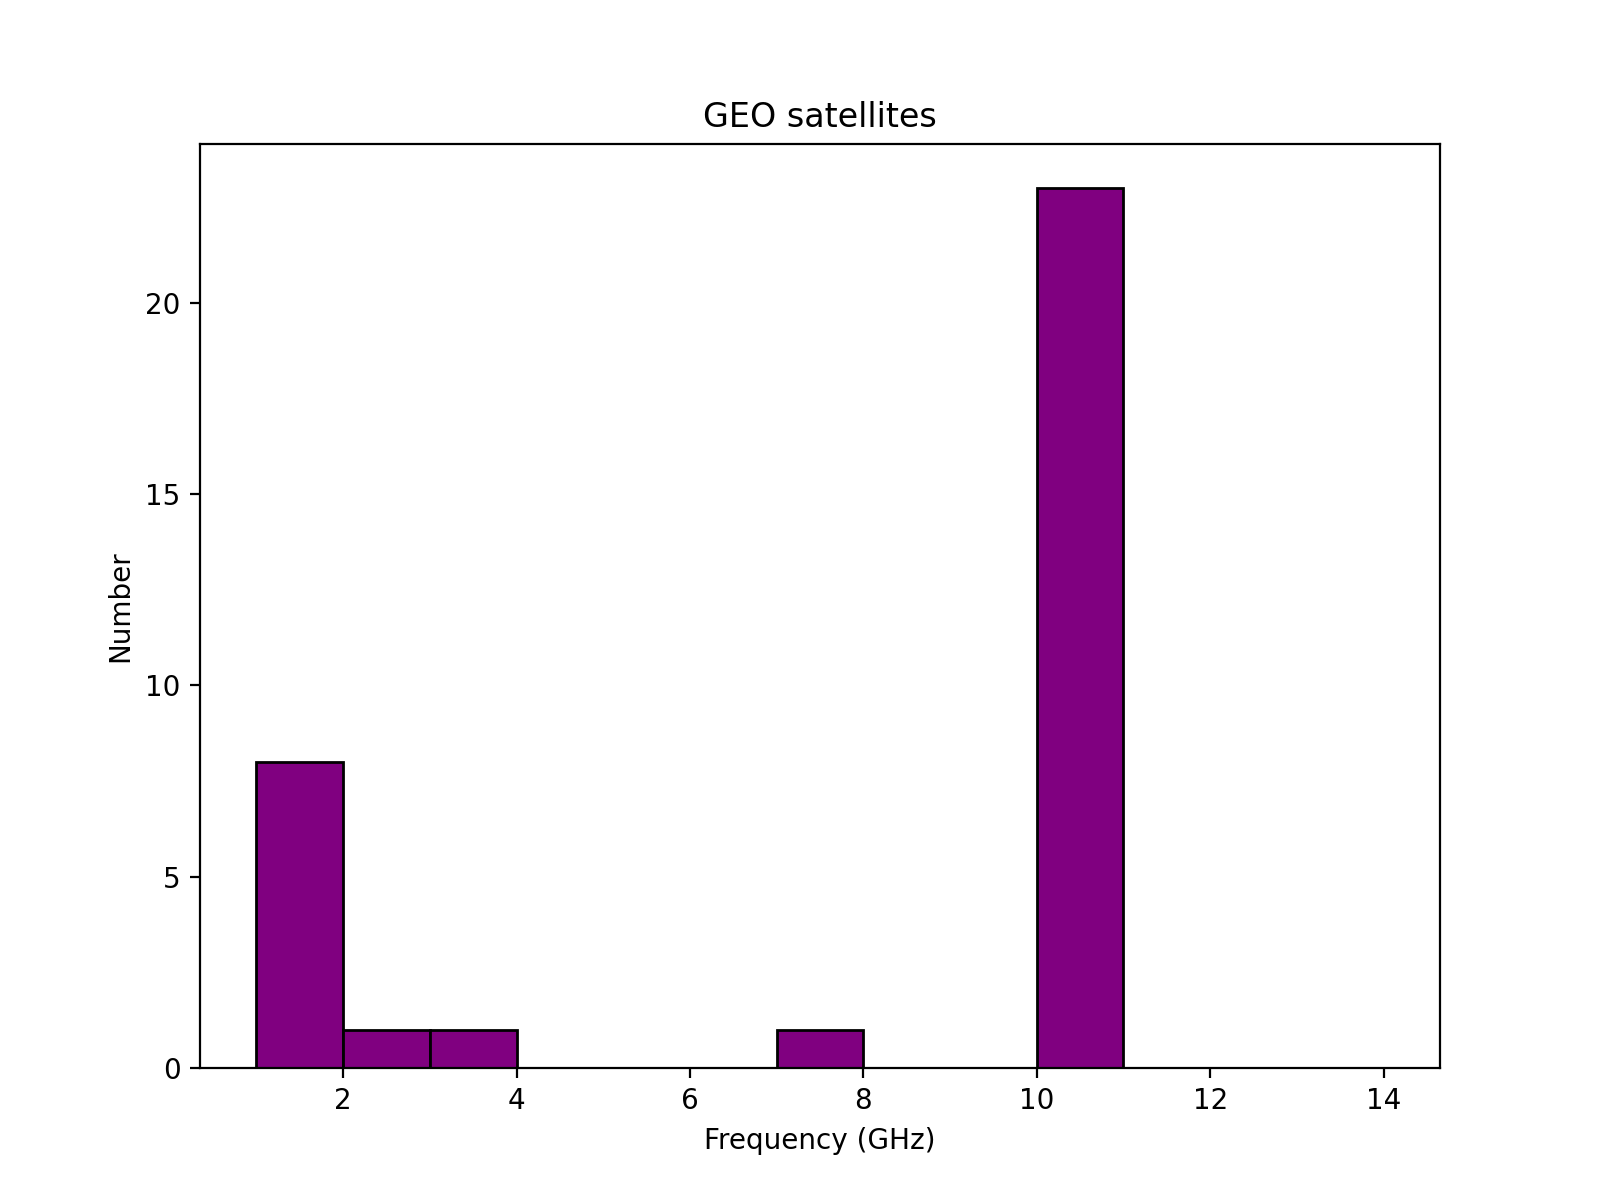

In [24]:
plt.figure(figsize = (8, 6))
plt.bar(x, ngeo, width = 1, color = 'purple', edgecolor = 'k')
plt.title('GEO satellites')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Number')
plt.show()

<IPython.core.display.Javascript object>


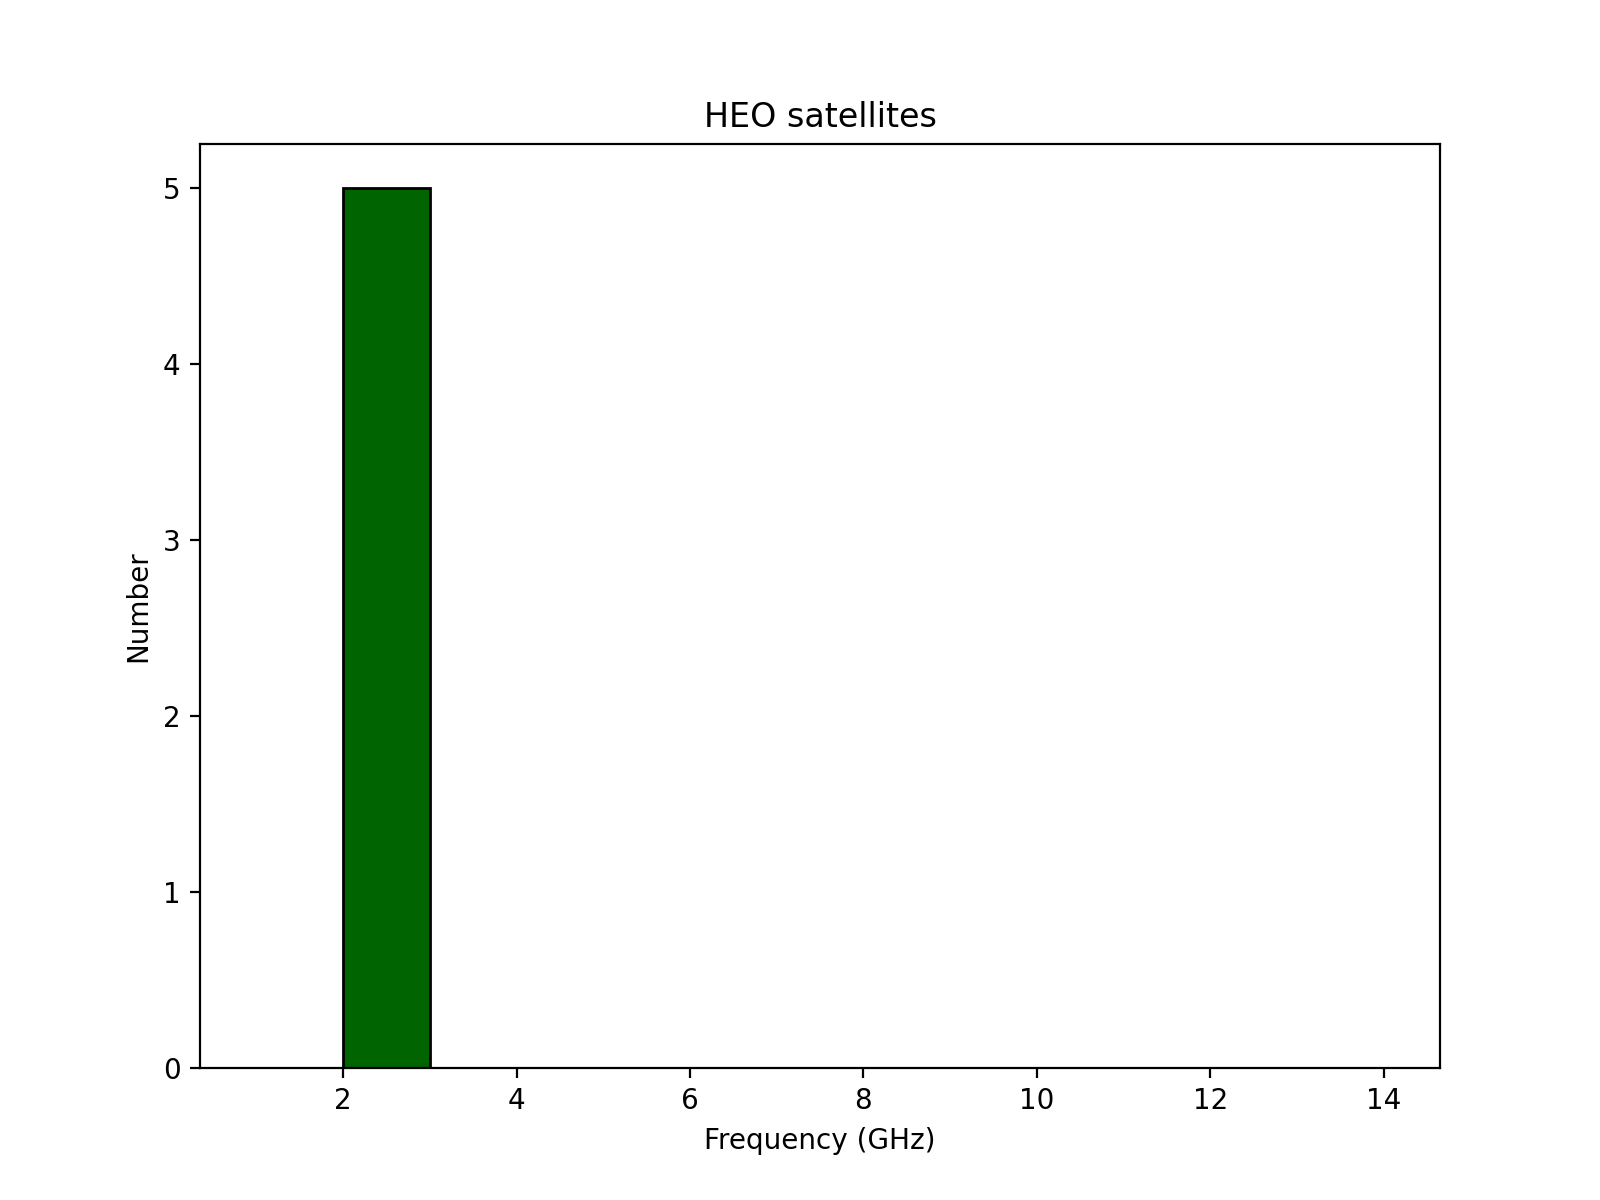

In [25]:
plt.figure(figsize = (8, 6))
plt.bar(x, nheo, width = 1, color = 'darkgreen', edgecolor = 'k')
plt.title('HEO satellites')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Number')
plt.show()

<IPython.core.display.Javascript object>


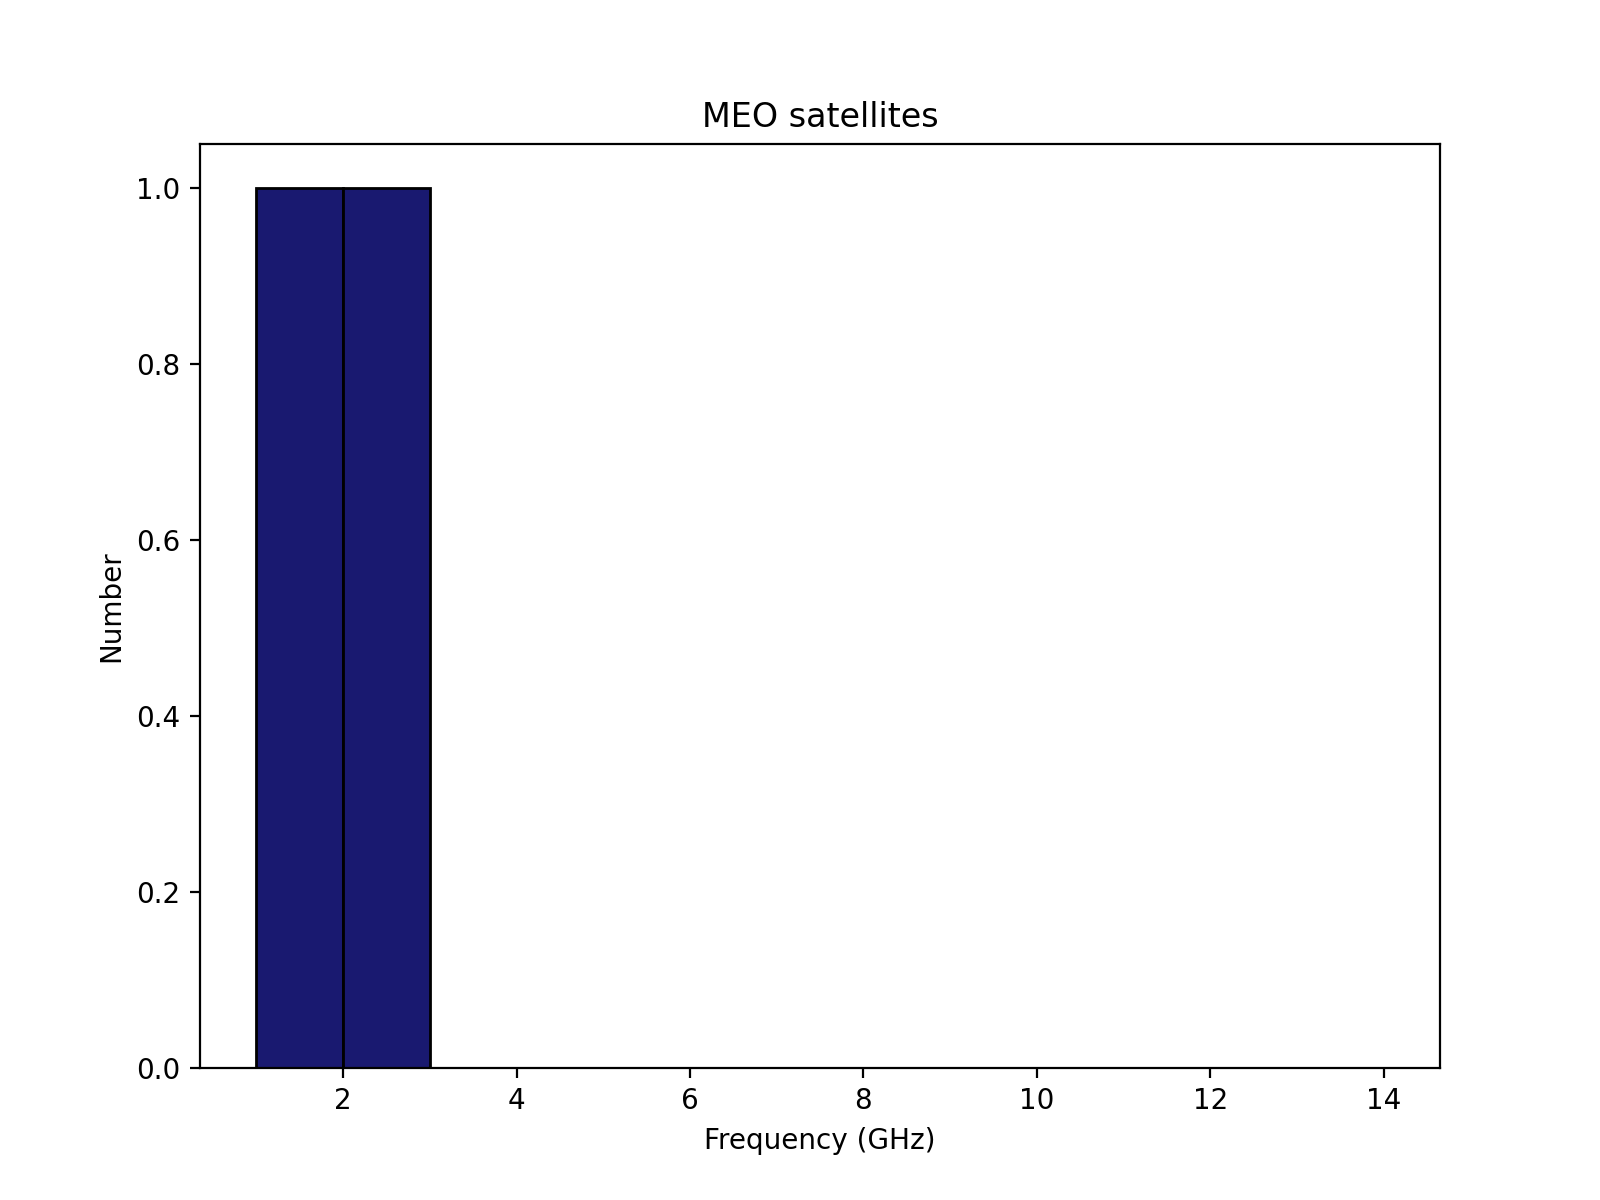

In [26]:
plt.figure(figsize = (8, 6))
plt.bar(x, nmeo, width = 1, color = 'midnightblue', edgecolor = 'k')
plt.title('MEO satellites')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Number')
plt.show()

<IPython.core.display.Javascript object>


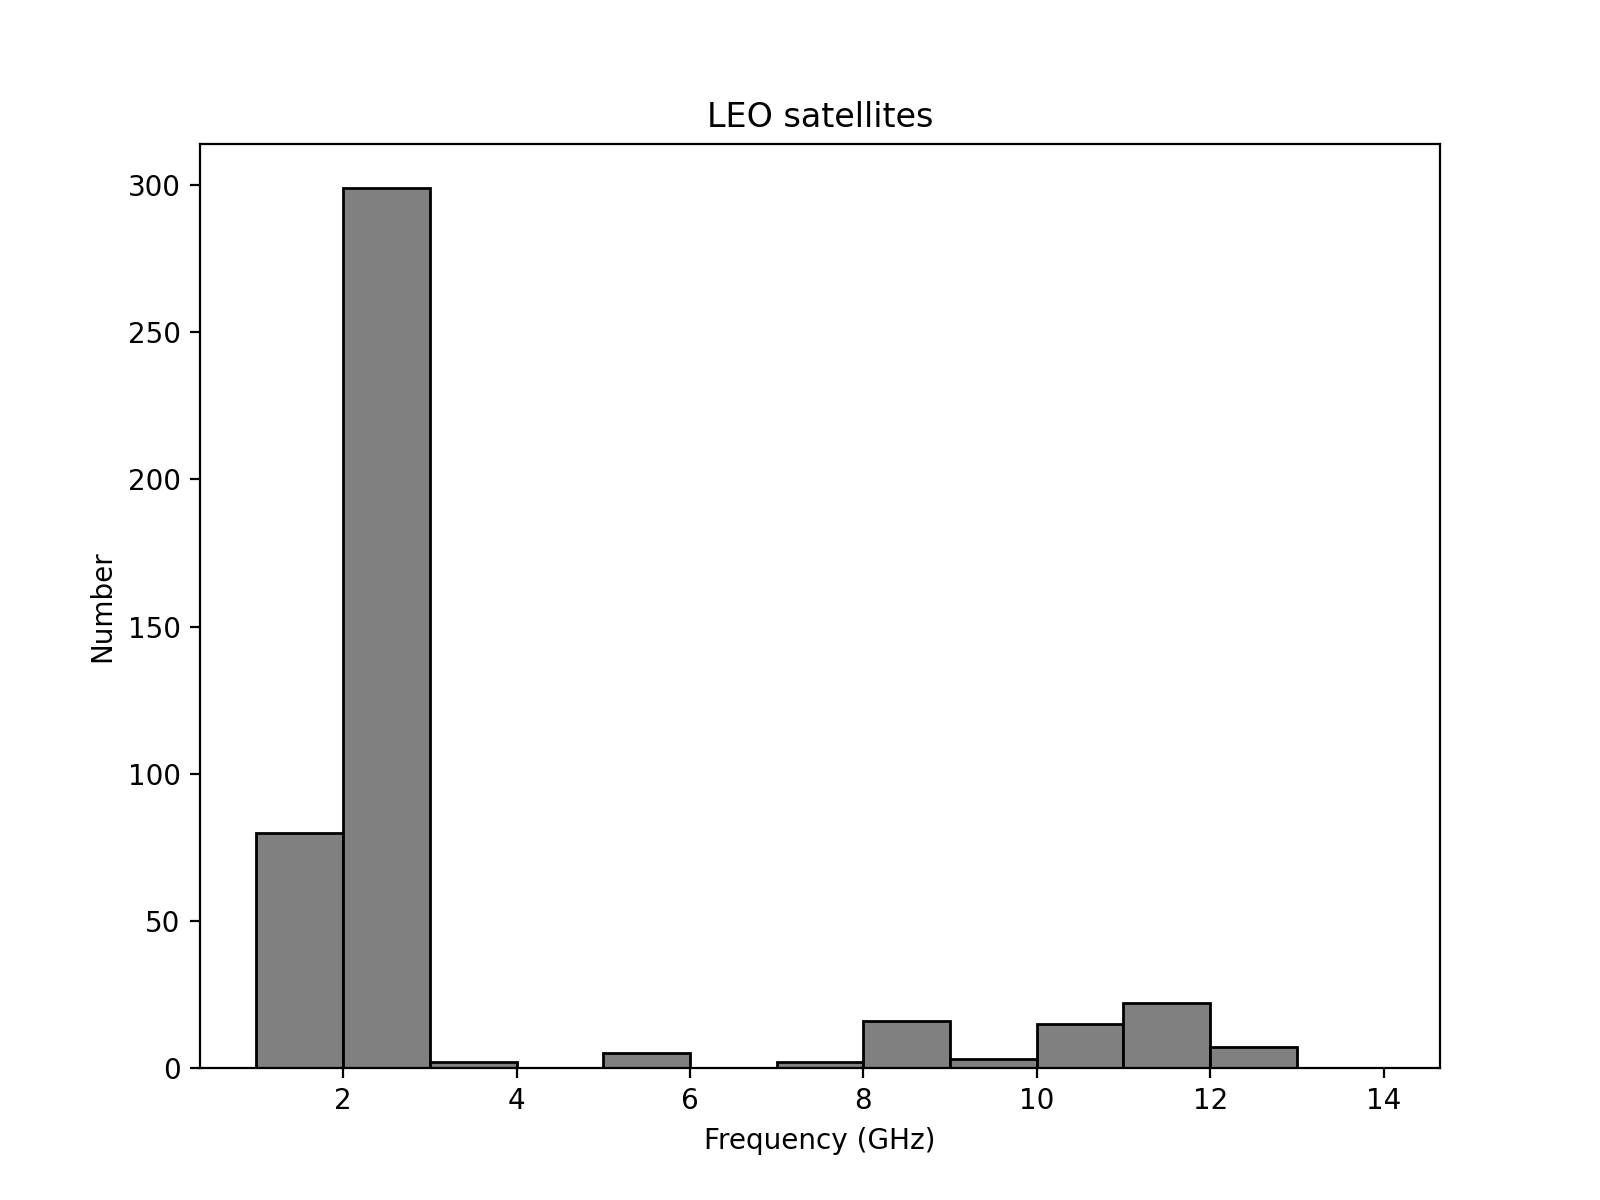

In [27]:
plt.figure(figsize = (8, 6))
plt.bar(x, nleo, width = 1, color = 'grey', edgecolor = 'k')
plt.title('LEO satellites')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Number')
plt.show()

<IPython.core.display.Javascript object>


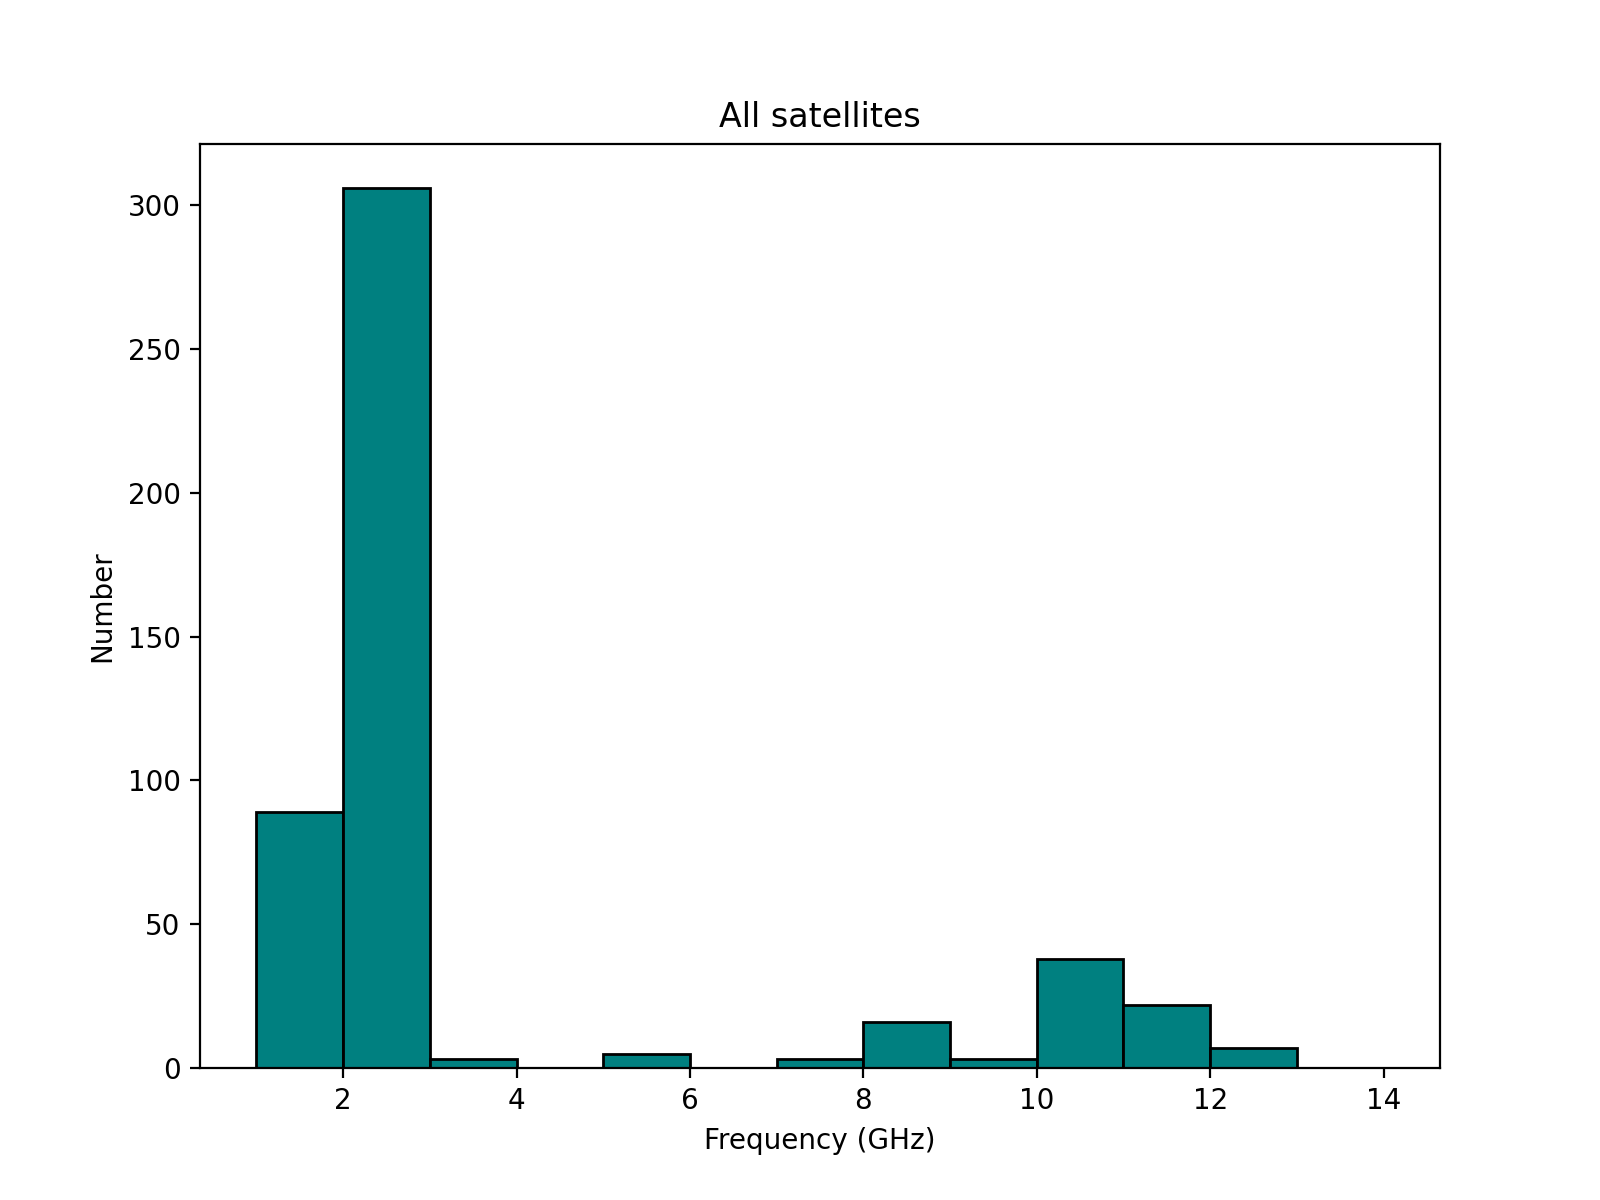

In [28]:
plt.figure(figsize = (8, 6))
plt.bar(x, nall, width = 1, color = 'teal', edgecolor = 'k')
plt.title('All satellites')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Number')
plt.show()

<IPython.core.display.Javascript object>


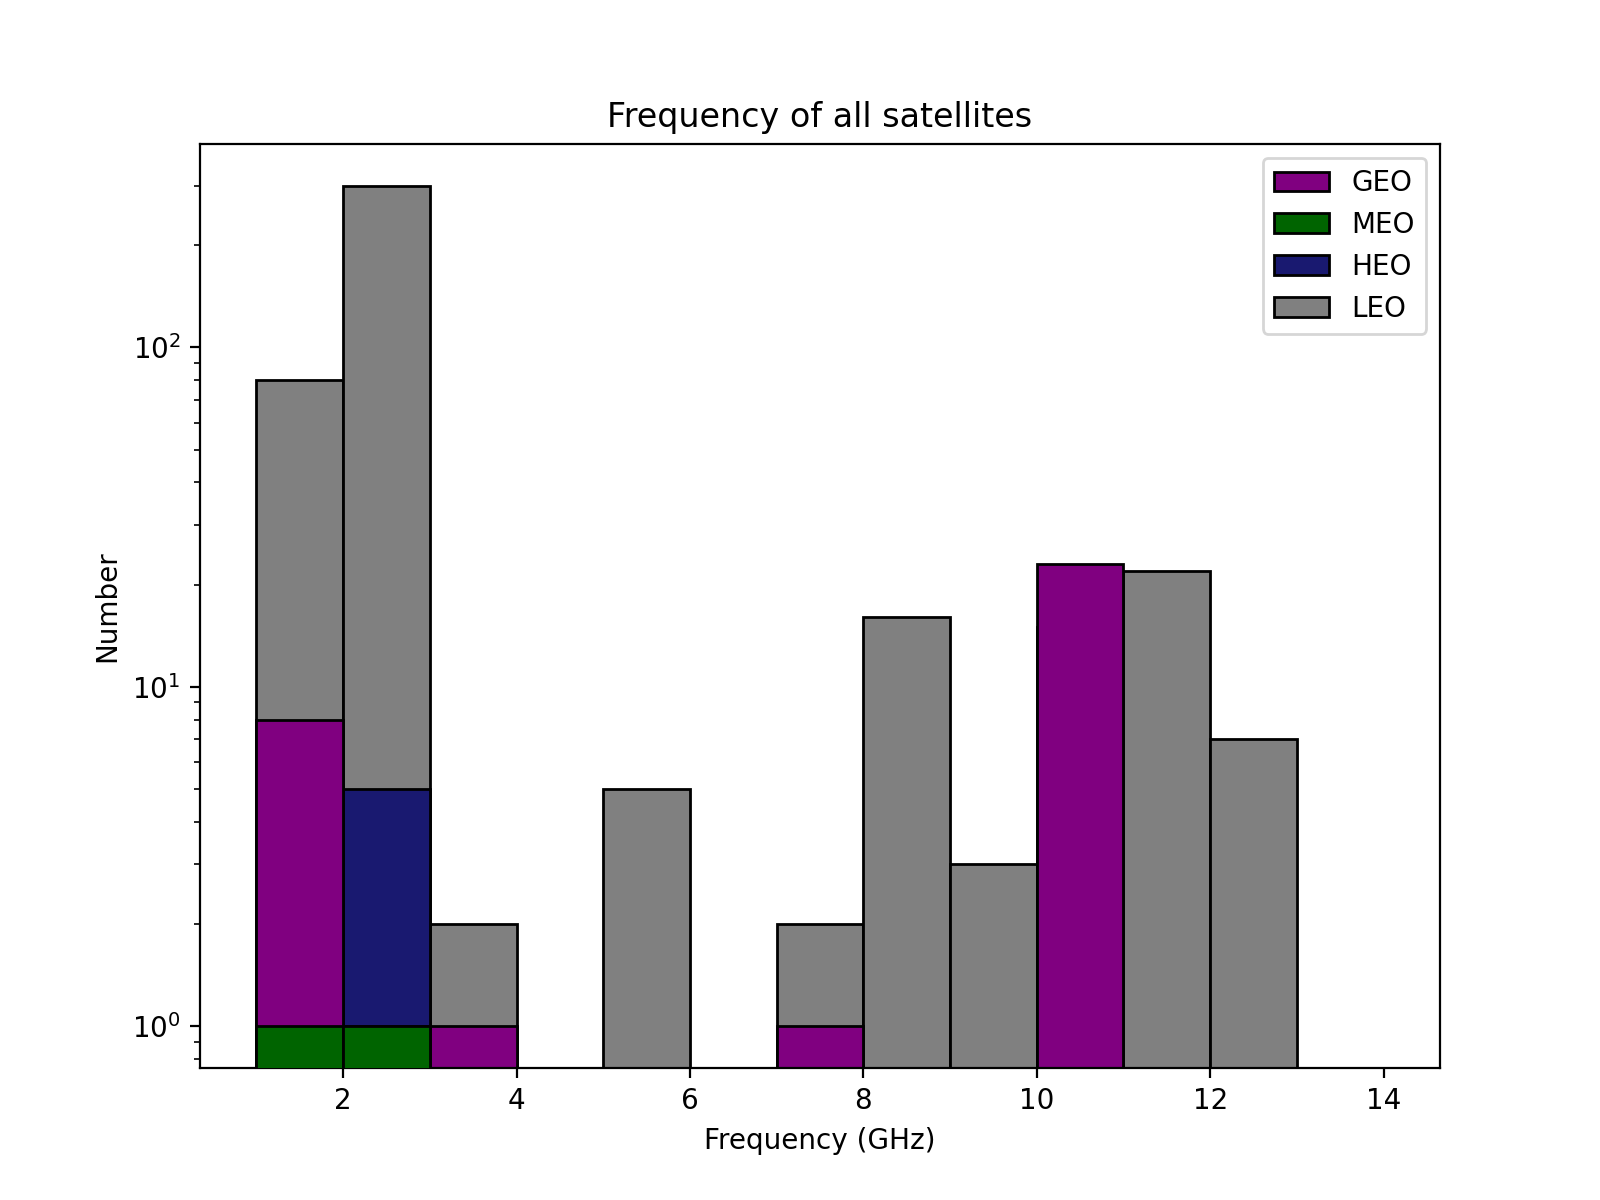

In [29]:
plt.figure(figsize = (8, 6))
plt.bar(x, ngeo, width = 1, color = 'purple', edgecolor = 'k' , zorder = 2, label = 'GEO')
plt.bar(x, nmeo, width = 1, color = 'darkgreen', edgecolor = 'k', zorder = 6, label = "MEO")
plt.bar(x, nheo, width = 1, color = 'midnightblue', edgecolor = 'k', zorder = 1, label = 'HEO')
plt.bar(x, nleo, width = 1, color = 'grey', edgecolor = 'k', zorder = 0, label = 'LEO')
plt.legend()
plt.yscale('log')
plt.title('Frequency of all satellites')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Number')
plt.show()

Making the mollweide plots for the different frequencies

In [30]:
import healpy as hp
from healpy.newvisufunc import projview

In [31]:
alt = np.reshape(alt, (len(active), len(t)))
az = np.reshape(az, (len(active), len(t)))

In [32]:
%%time
GEO_altf = []
GEO_azf = []
HEO_altf = []
HEO_azf = []
MEO_altf = []
MEO_azf = []
LEO_altf = []
LEO_azf = []
testleo = []

for i in range(len(n)):
    #print(i)
    for j in range(len(GEO)):
        if n[i] == GEO[j]:
            for k in range(len(t)):
                if alt[n[i]][k] > 0:
                #if qgeo5r[j][k] != 0:
                    GEO_altf.append(np.abs(alt[n[i]][k] - 90))
                    GEO_azf.append(az[n[i]][k])
                elif alt[n[i]][k] <= 0:
                    GEO_altf.append(0)
                    GEO_azf.append(0)
                    
for i in range(len(n)):
    for j in range(len(MEO)):
        if n[i] == MEO[j]:
            for k in range(len(t)):
                if alt[n[i]][k] > 0:
                #if qmeo5r[j][k] != 0:
                    MEO_altf.append(np.abs(alt[n[i]][k] - 90))
                    MEO_azf.append(az[n[i]][k])
                elif alt[n[i]][k] <= 0:
                    MEO_altf.append(0)
                    MEO_azf.append(0)
                
for i in range(len(n)):
    for j in range(len(HEO)):
        if n[i] == HEO[j]:
            for k in range(len(t)):
                if alt[n[i]][k] > 0:
                #if qheo5r[j][k] != 0:
                    HEO_altf.append(np.abs(alt[n[i]][k] - 90))
                    HEO_azf.append(az[n[i]][k])
                elif alt[n[i]][k] <= 0:
                    HEO_altf.append(0)
                    HEO_azf.append(0)
                
for h in range(len(n)):
    for j in range(len(LEO)):
        if n[h] == LEO[j]:
            for k in range(len(t)):
                if alt[n[h]][k] > 0:
                    testleo.append(n[h])
                    LEO_altf.append(np.abs(alt[n[h]][k] - 90))
                    LEO_azf.append(az[n[h]][k])
                elif alt[n[h]][k] <= 0:
                    LEO_altf.append(0)
                    LEO_azf.append(0)

CPU times: user 1.38 s, sys: 25.9 ms, total: 1.4 s
Wall time: 1.43 s


In [33]:
GEO_altf = np.reshape(GEO_altf, (len(GEO_freq), 144))
GEO_azf = np.reshape(GEO_azf, (len(GEO_freq), 144))

HEO_altf = np.reshape(HEO_altf, (len(HEO_freq), 144))
HEO_azf = np.reshape(HEO_azf, (len(HEO_freq), 144))

MEO_altf = np.reshape(MEO_altf, (len(MEO_freq), 144))
MEO_azf = np.reshape(MEO_azf, (len(MEO_freq), 144))

LEO_altf = np.reshape(LEO_altf, (len(LEO_freq), 144))
LEO_azf = np.reshape(LEO_azf, (len(LEO_freq), 144))

In [34]:
%%time
altf12 = []
altf23 = []
altf34 = []
altf45 = []
altf56 = []
altf67 = []
altf78 = []
altf89 = []
altf910 = []
altf1011 = []
altf1112 = []
altf1213 = []
altf1314 = []

azf12 = []
azf23 = []
azf34 = []
azf45 = []
azf56 = []
azf67 = []
azf78 = []
azf89 = []
azf910 = []
azf1011 = []
azf1112 = []
azf1213 = []
azf1314 = []
for i in range(len(GEO_altf)):
    for j in range(len(t)):
        if GEO_altf[i][j] != 0:
            if 1 <= GEO_freq[i] < (2):
                altf12.append(GEO_altf[i][j])
                azf12.append(GEO_azf[i][j])
            if 2 <= GEO_freq[i] < (3):
                altf23.append(GEO_altf[i][j])
                azf23.append(GEO_azf[i][j])
            if 3 <= GEO_freq[i] < (4):
                altf34.append(GEO_altf[i][j])
                azf34.append(GEO_azf[i][j])
            if 4 <= GEO_freq[i] < (5):
                altf45.append(GEO_altf[i][j])
                azf45.append(GEO_azf[i][j])
            if 5 <= GEO_freq[i] < (6):
                altf56.append(GEO_altf[i][j])
                azf56.append(GEO_azf[i][j])
            if 6 <= GEO_freq[i] < (7):
                altf67.append(GEO_altf[i][j])
                azf67.append(GEO_azf[i][j])
            if 7 <= GEO_freq[i] < (8):
                altf78.append(GEO_altf[i][j])
                azf78.append(GEO_azf[i][j])
            if 8 <= GEO_freq[i] < (9):
                altf89.append(GEO_altf[i][j])
                azf89.append(GEO_azf[i][j])
            if 9 <= GEO_freq[i] < (10):
                altf910.append(GEO_altf[i][j])
                azf910.append(GEO_azf[i][j])
            if 10 <= GEO_freq[i] < (11):
                altf1011.append(GEO_altf[i][j])
                azf1011.append(GEO_azf[i][j])
            if 11 <= GEO_freq[i] < (12):
                altf1112.append(GEO_altf[i][j])
                azf1112.append(GEO_azf[i][j])
            if 12 <= GEO_freq[i] < (13):
                altf1213.append(GEO_altf[i][j])
                azf1213.append(GEO_azf[i][j])
            if 13 <= GEO_freq[i] < (14):
                altf1314.append(GEO_altf[i][j])
                azf1314.append(GEO_azf[i][j])
        
for i in range(len(MEO_altf)):
    for j in range(len(t)):
        if MEO_altf[i][j] != 0:
            if 1 <= MEO_freq[i] < (2):
                altf12.append(MEO_altf[i][j])
                azf12.append(MEO_azf[i][j])
            if 2 <= MEO_freq[i] < (3):
                altf23.append(MEO_altf[i][j])
                azf23.append(MEO_azf[i][j])
            if 3 <= MEO_freq[i] < (4):
                altf34.append(MEO_altf[i][j])
                azf34.append(MEO_azf[i][j])
            if 4 <= MEO_freq[i] < (5):
                altf45.append(MEO_altf[i][j])
                azf45.append(MEO_azf[i][j])
            if 5 <= MEO_freq[i] < (6):
                altf56.append(MEO_altf[i][j])
                azf56.append(MEO_azf[i][j])
            if 6 <= MEO_freq[i] < (7):
                altf67.append(MEO_altf[i][j])
                azf67.append(MEO_azf[i][j])
            if 7 <= MEO_freq[i] < (8):
                altf78.append(MEO_altf[i][j])
                azf78.append(MEO_azf[i][j])
            if 8 <= MEO_freq[i] < (9):
                altf89.append(MEO_altf[i][j])
                azf89.append(MEO_azf[i][j])
            if 9 <= MEO_freq[i] < (10):
                altf910.append(MEO_altf[i][j])
                azf910.append(MEO_azf[i][j])
            if 10 <= MEO_freq[i] < (11):
                altf1011.append(MEO_altf[i][j])
                azf1011.append(MEO_azf[i][j])
            if 11 <= MEO_freq[i] < (12):
                altf1112.append(MEO_altf[i][j])
                azf1112.append(MEO_azf[i][j])
            if 12 <= MEO_freq[i] < (13):
                altf1213.append(MEO_altf[i][j])
                azf1213.append(MEO_azf[i][j])
            if 13 <= MEO_freq[i] < (14):
                altf1314.append(MEO_altf[i][j])
                azf1314.append(MEO_azf[i][j])

for i in range(len(HEO_altf)):
    for j in range(len(t)):
        if HEO_altf[i][j] != 0:
            if 1 <= HEO_freq[i] < (2):
                altf12.append(HEO_altf[i][j])
                azf12.append(HEO_azf[i][j])
            if 2 <= HEO_freq[i] < (3):
                altf23.append(HEO_altf[i][j])
                azf23.append(HEO_azf[i][j])
            if 3 <= HEO_freq[i] < (4):
                altf34.append(HEO_altf[i][j])
                azf34.append(HEO_azf[i][j])
            if 4 <= HEO_freq[i] < (5):
                altf45.append(HEO_altf[i][j])
                azf45.append(HEO_azf[i][j])
            if 5 <= HEO_freq[i] < (6):
                altf56.append(HEO_altf[i][j])
                azf56.append(HEO_azf[i][j])
            if 6 <= HEO_freq[i] < (7):
                altf67.append(HEO_altf[i][j])
                azf67.append(HEO_azf[i][j])
            if 7 <= HEO_freq[i] < (8):
                altf78.append(HEO_altf[i][j])
                azf78.append(HEO_azf[i][j])
            if 8 <= HEO_freq[i] < (9):
                altf89.append(HEO_altf[i][j])
                azf89.append(HEO_azf[i][j])
            if 9 <= HEO_freq[i] < (10):
                altf910.append(HEO_altf[i][j])
                azf910.append(HEO_azf[i][j])
            if 10 <= HEO_freq[i] < (11):
                altf1011.append(HEO_altf[i][j])
                azf1011.append(HEO_azf[i][j])
            if 11 <= HEO_freq[i] < (12):
                altf1112.append(HEO_altf[i][j])
                azf1112.append(HEO_azf[i][j])
            if 12 <= HEO_freq[i] < (13):
                altf1213.append(HEO_altf[i][j])
                azf1213.append(HEO_azf[i][j])
            if 13 <= HEO_freq[i] < (14):
                altf1314.append(HEO_altf[i][j])
                azf1314.append(HEO_azf[i][j])

for i in range(len(LEO_altf)):
    for j in range(len(t)):
        if LEO_altf[i][j] != 0:
            if 1 <= LEO_freq[i] < (2):
                altf12.append(LEO_altf[i][j])
                azf12.append(LEO_azf[i][j])
            if 2 <= LEO_freq[i] < (3):
                altf23.append(LEO_altf[i][j])
                azf23.append(LEO_azf[i][j])
            if 3 <= LEO_freq[i] < (4):
                altf34.append(LEO_altf[i][j])
                azf34.append(LEO_azf[i][j])
            if 4 <= LEO_freq[i] < (5):
                altf45.append(LEO_altf[i][j])
                azf45.append(LEO_azf[i][j])
            if 5 <= LEO_freq[i] < (6):
                altf56.append(LEO_altf[i][j])
                azf56.append(LEO_azf[i][j])
            if 6 <= LEO_freq[i] < (7):
                altf67.append(LEO_altf[i][j])
                azf67.append(LEO_azf[i][j])
            if 7 <= LEO_freq[i] < (8):
                altf78.append(LEO_altf[i][j])
                azf78.append(LEO_azf[i][j])
            if 8 <= LEO_freq[i] < (9):
                altf89.append(LEO_altf[i][j])
                azf89.append(LEO_azf[i][j])
            if 9 <= LEO_freq[i] < (10):
                altf910.append(LEO_altf[i][j])
                azf910.append(LEO_azf[i][j])
            if 10 <= LEO_freq[i] < (11):
                altf1011.append(LEO_altf[i][j])
                azf1011.append(LEO_azf[i][j])
            if 11 <= LEO_freq[i] < (12):
                altf1112.append(LEO_altf[i][j])
                azf1112.append(LEO_azf[i][j])
            if 12 <= LEO_freq[i] < (13):
                altf1213.append(LEO_altf[i][j])
                azf1213.append(LEO_azf[i][j])
            if 13 <= LEO_freq[i] < (14):
                altf1314.append(LEO_altf[i][j])
                azf1314.append(LEO_azf[i][j])

CPU times: user 63.1 ms, sys: 5.52 ms, total: 68.6 ms
Wall time: 104 ms


In [35]:
data = [np.arange(len(altf12)), np.arange(len(altf23)), np.arange(len(altf34)), np.arange(len(altf45)), 
        np.arange(len(altf56)), np.arange(len(altf67)), np.arange(len(altf78)), np.arange(len(altf89)), 
        np.arange(len(altf910)), np.arange(len(altf1011)), np.arange(len(altf1112)), np.arange(len(altf1213)), 
        np.arange(len(altf1314))]
theta = [np.radians(altf12), np.radians(altf23), np.radians(altf34), np.radians(altf45), np.radians(altf56),
         np.radians(altf67), np.radians(altf78), np.radians(altf89), np.radians(altf910), np.radians(altf1011),
         np.radians(altf1112), np.radians(altf1213), np.radians(altf1314)]
phi = [np.radians(azf12), np.radians(azf23), np.radians(azf34), np.radians(azf45), np.radians(azf56),
       np.radians(azf67), np.radians(azf78), np.radians(azf89), np.radians(azf910), np.radians(azf1011),
       np.radians(azf1112), np.radians(azf1213), np.radians(azf1314)]


In [36]:
nside = 2**5

In [37]:
(hp.nside2resol(nside) * u.rad).to(u.degree)

<Quantity 1.83225942 deg>

In [38]:
#Turning to face due South again
for i in range(len(phi)):
    for j in range(len(phi[i])):
        if (phi[i][j] + np.pi) >= (2*np.pi):
            phi[i][j] = phi[i][j] - np.pi
        elif (phi[i][j] + np.pi) < (2*np.pi):
            phi[i][j] = phi[i][j] + np.pi

In [39]:
pixel_indices_f = []
paf = []
for i in range(0, 13):
    pixel_indices_f.append(hp.ang2pix(nside, theta[i], phi[i]))
    paf.append(hp.ang2pix(nside, theta[i], phi[i]))

In [40]:
for i in range(len(pixel_indices_f)):
    for j in range(len(pixel_indices_f[i])-1):
        if paf[i][j] == paf[i][j+1]:
            pixel_indices_f[i][j+1] = 0

In [41]:
m12 = np.zeros(hp.nside2npix(nside))
m23 = np.zeros(hp.nside2npix(nside))
m34 = np.zeros(hp.nside2npix(nside))
m45 = np.zeros(hp.nside2npix(nside))
m56 = np.zeros(hp.nside2npix(nside))
m67 = np.zeros(hp.nside2npix(nside))
m78 = np.zeros(hp.nside2npix(nside))
m89 = np.zeros(hp.nside2npix(nside))
m910 = np.zeros(hp.nside2npix(nside))
m1011 = np.zeros(hp.nside2npix(nside))
m1112 = np.zeros(hp.nside2npix(nside))
m1213 = np.zeros(hp.nside2npix(nside))
m1314 = np.zeros(hp.nside2npix(nside))

In [42]:
%%time
for i in range(1, len(m12)):
    for j in range(len(pixel_indices_f[0])):
        if i == pixel_indices_f[0][j]:
            m12[i] += 1
for i in range(1, len(m23)):
    for j in range(len(pixel_indices_f[1])):
        if i == pixel_indices_f[1][j]:
            m23[i] += 1
for i in range(1, len(m34)):
    for j in range(len(pixel_indices_f[2])):
        if i == pixel_indices_f[2][j]:
            m34[i] += 1
for i in range(1, len(m45)):
    for j in range(len(pixel_indices_f[3])):
        if i == pixel_indices_f[3][j]:
            m45[i] += 1
for i in range(1, len(m56)):
    for j in range(len(pixel_indices_f[4])):
        if i == pixel_indices_f[4][j]:
            m56[i] += 1
for i in range(1, len(m67)):
    #print(i)
    for j in range(len(pixel_indices_f[5])):
        if i == pixel_indices_f[5][j]:
            m67[i] += 1
for i in range(1, len(m78)):
    for j in range(len(pixel_indices_f[6])):
        if i == pixel_indices_f[6][j]:
            m78[i] += 1
for i in range(1, len(m89)):
    for j in range(len(pixel_indices_f[7])):
        if i == pixel_indices_f[7][j]:
            m89[i] += 1
for i in range(1, len(m910)):
    for j in range(len(pixel_indices_f[8])):
        if i == pixel_indices_f[8][j]:
            m910[i] += 1
for i in range(1, len(m1011)):
    for j in range(len(pixel_indices_f[9])):
        if i == pixel_indices_f[9][j]:
            m1011[i] += 1
for i in range(1, len(m1112)):
    for j in range(len(pixel_indices_f[10])):
        if i == pixel_indices_f[10][j]:
            m1112[i] += 1
for i in range(1 ,len(m1213)):
    for j in range(len(pixel_indices_f[11])):
        if i == pixel_indices_f[11][j]:
            m1213[i] += 1
for i in range(1, len(m1314)):
    for j in range(len(pixel_indices_f[12])):
        if i == pixel_indices_f[12][j]:
            m1314[i] += 1

CPU times: user 4.27 s, sys: 20.7 ms, total: 4.29 s
Wall time: 4.29 s


In [43]:
print(np.max(m12))
print(np.max(m23))
print(np.max(m34))
print(np.max(m45))
print(np.max(m56))
print(np.max(m67))
print(np.max(m78))
print(np.max(m89))
print(np.max(m910))
print(np.max(m1011))
print(np.max(m1112))
print(np.max(m1213))
print(np.max(m1314))

6.0
10.0
1.0
0.0
2.0
0.0
1.0
2.0
1.0
4.0
4.0
1.0
0.0


<IPython.core.display.Javascript object>


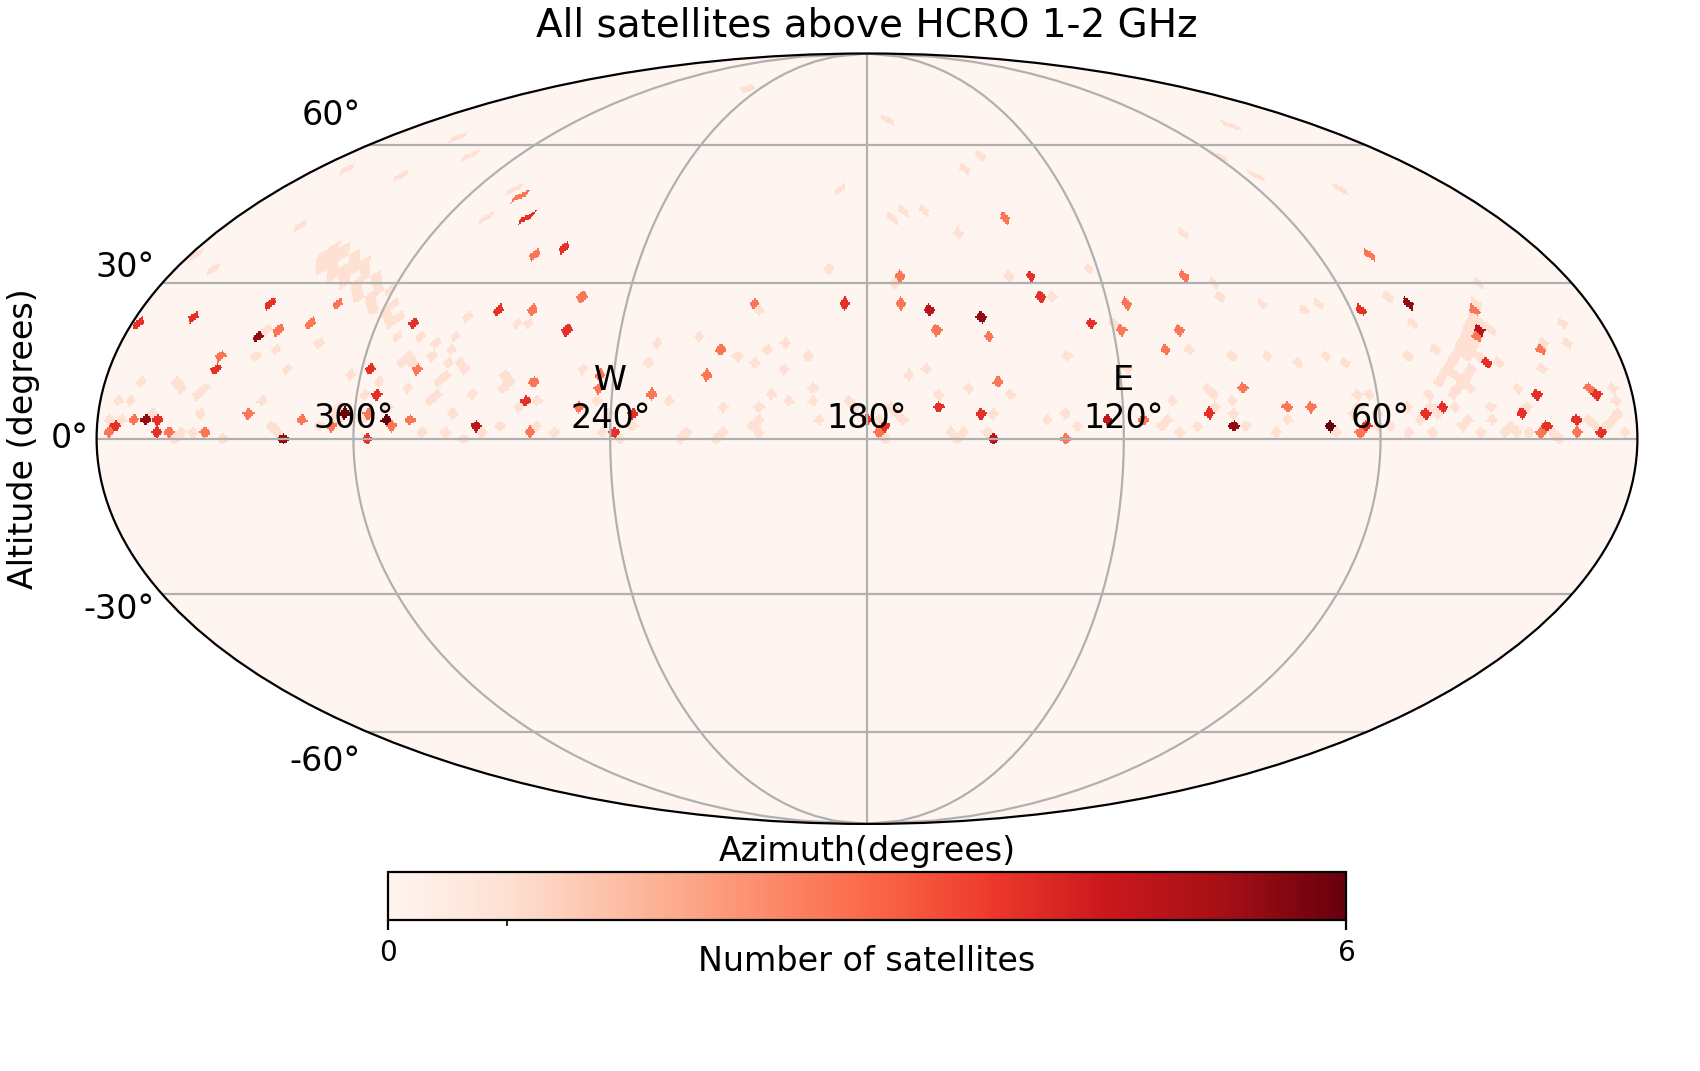

<IPython.core.display.Javascript object>


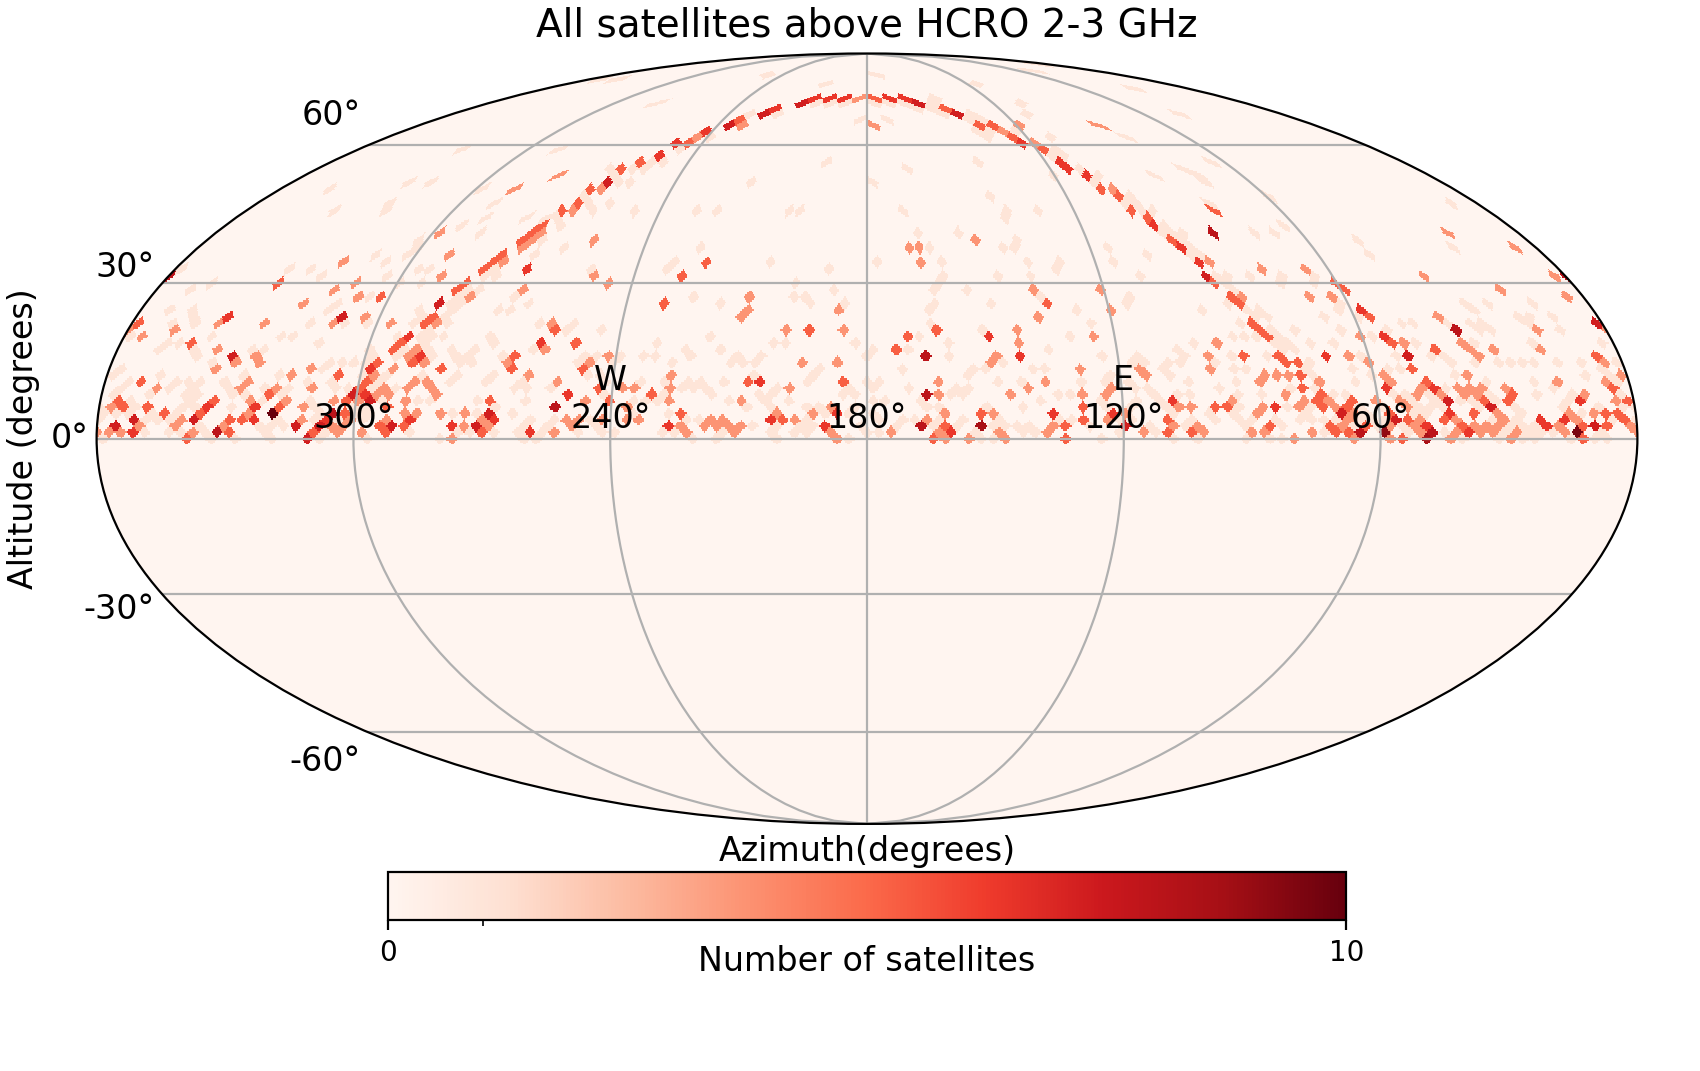

<IPython.core.display.Javascript object>


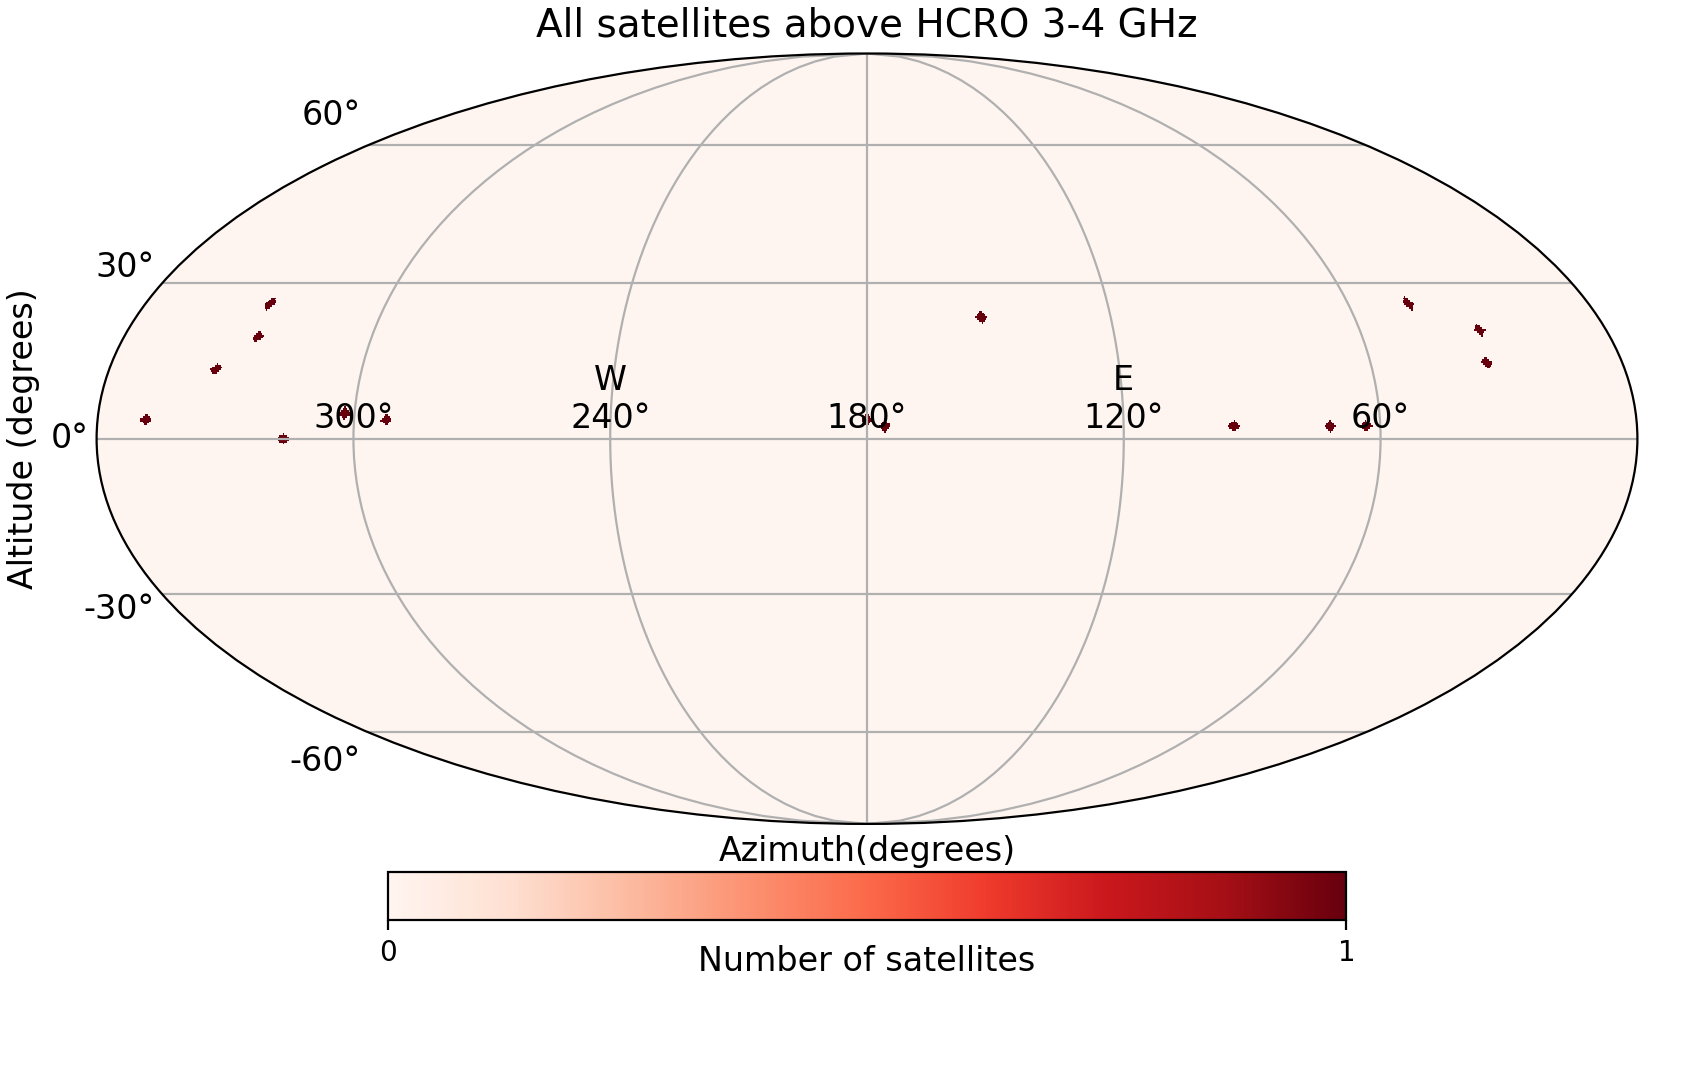

<IPython.core.display.Javascript object>


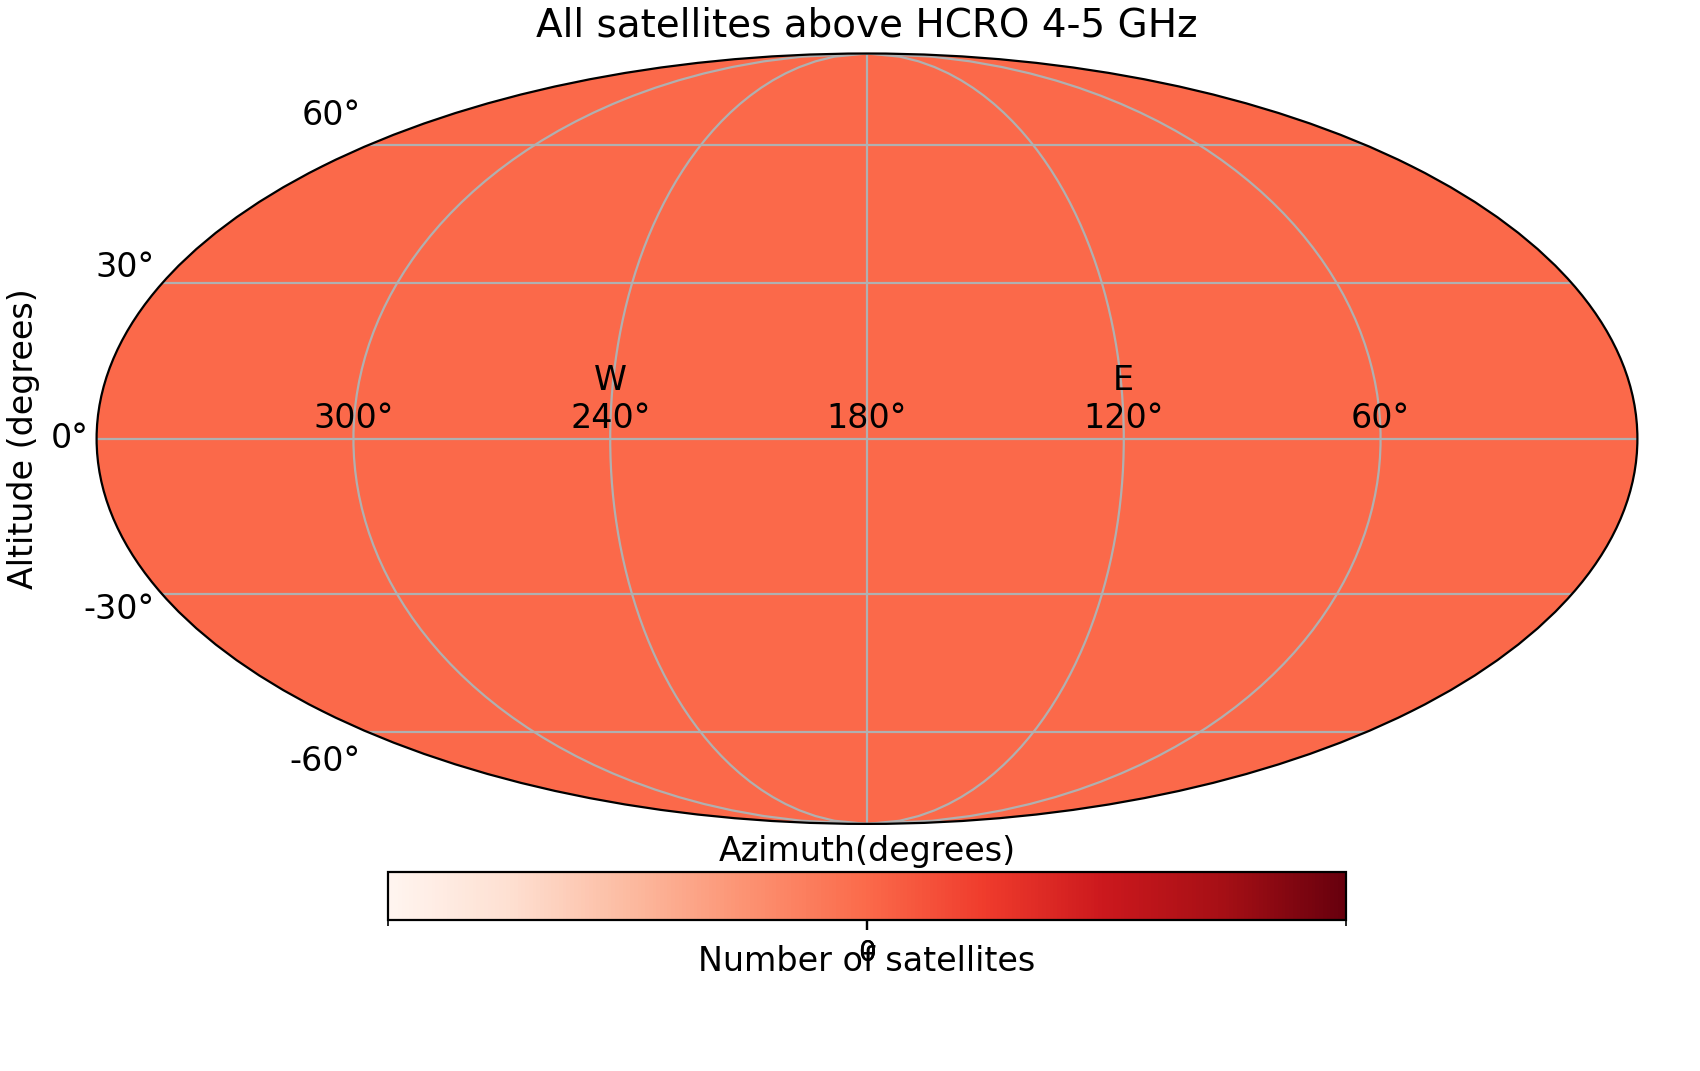

<IPython.core.display.Javascript object>


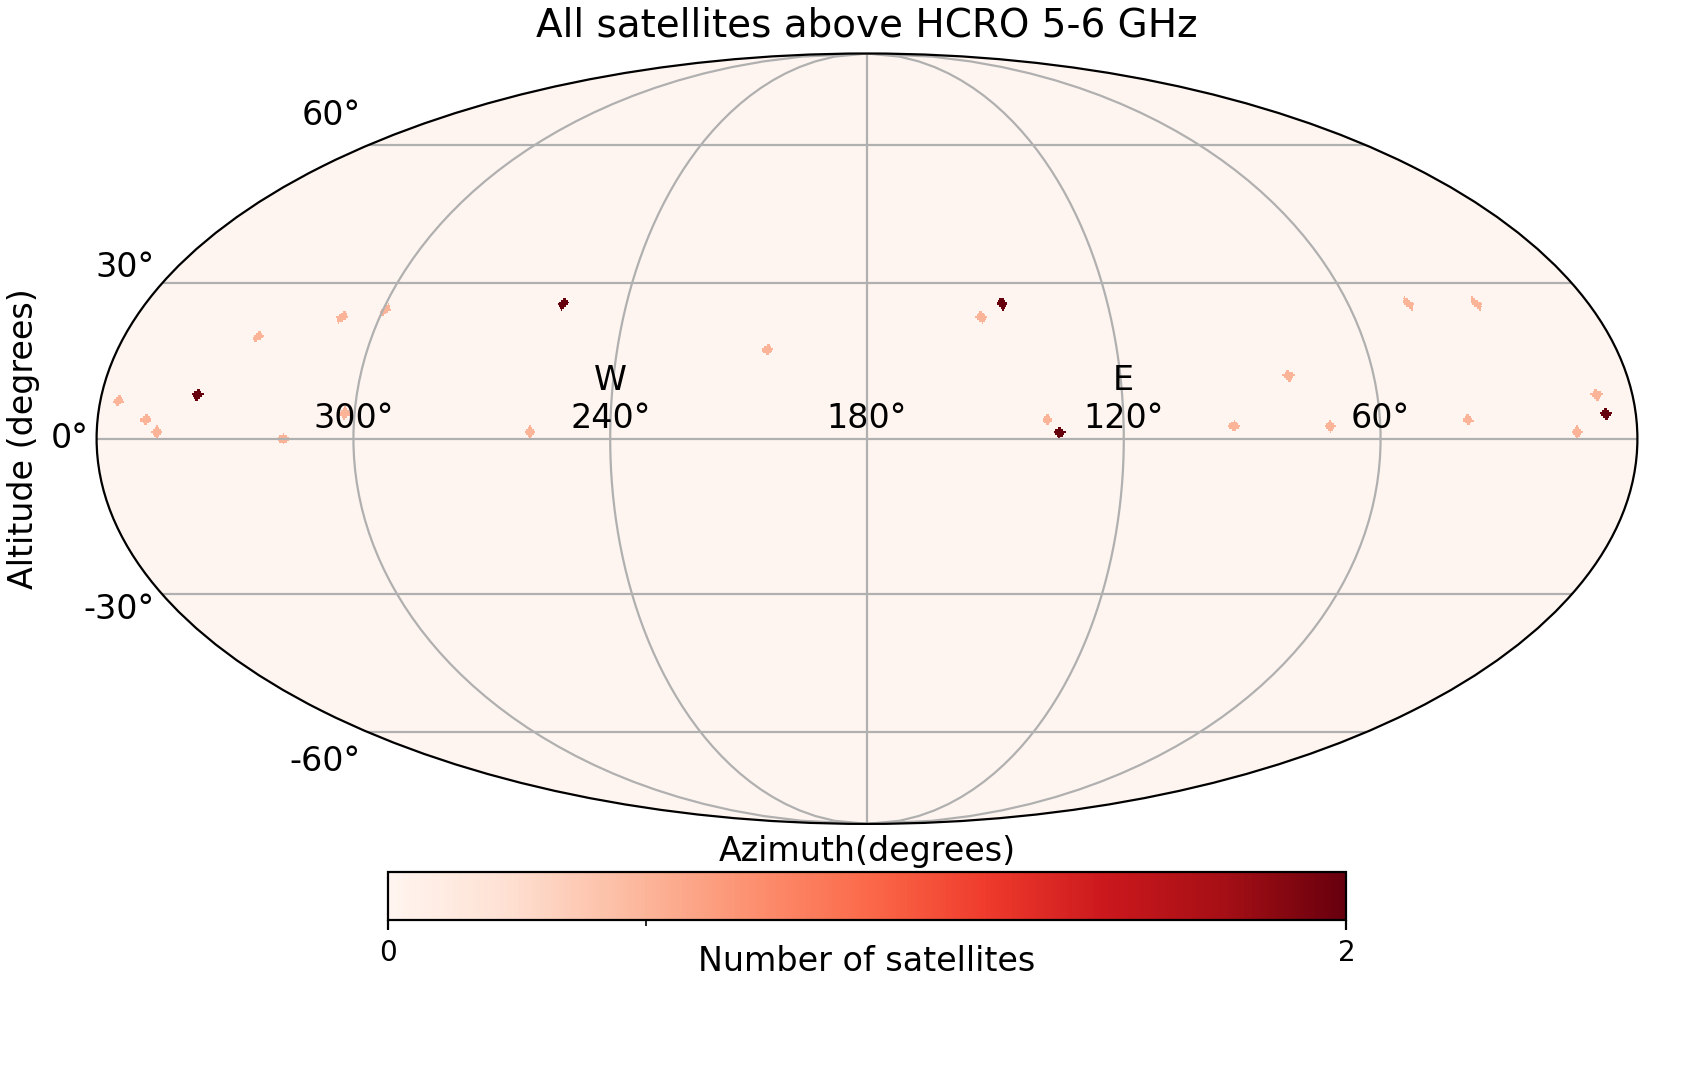

<IPython.core.display.Javascript object>


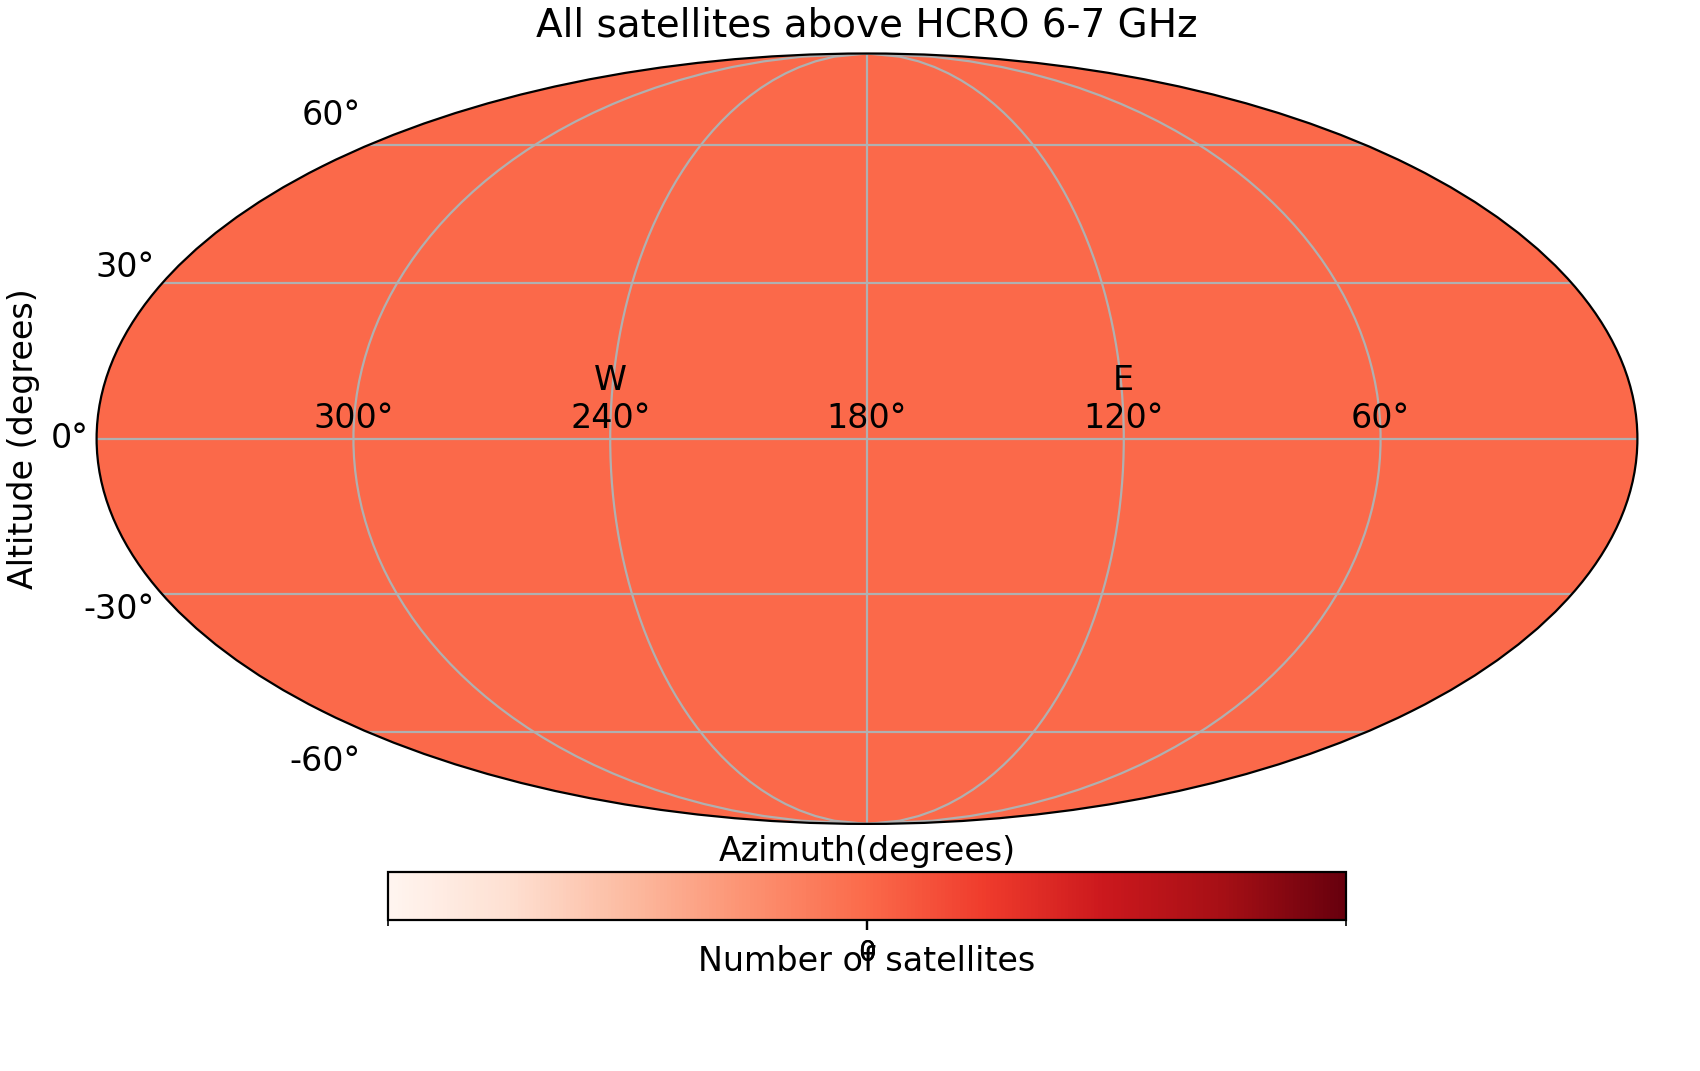

<IPython.core.display.Javascript object>


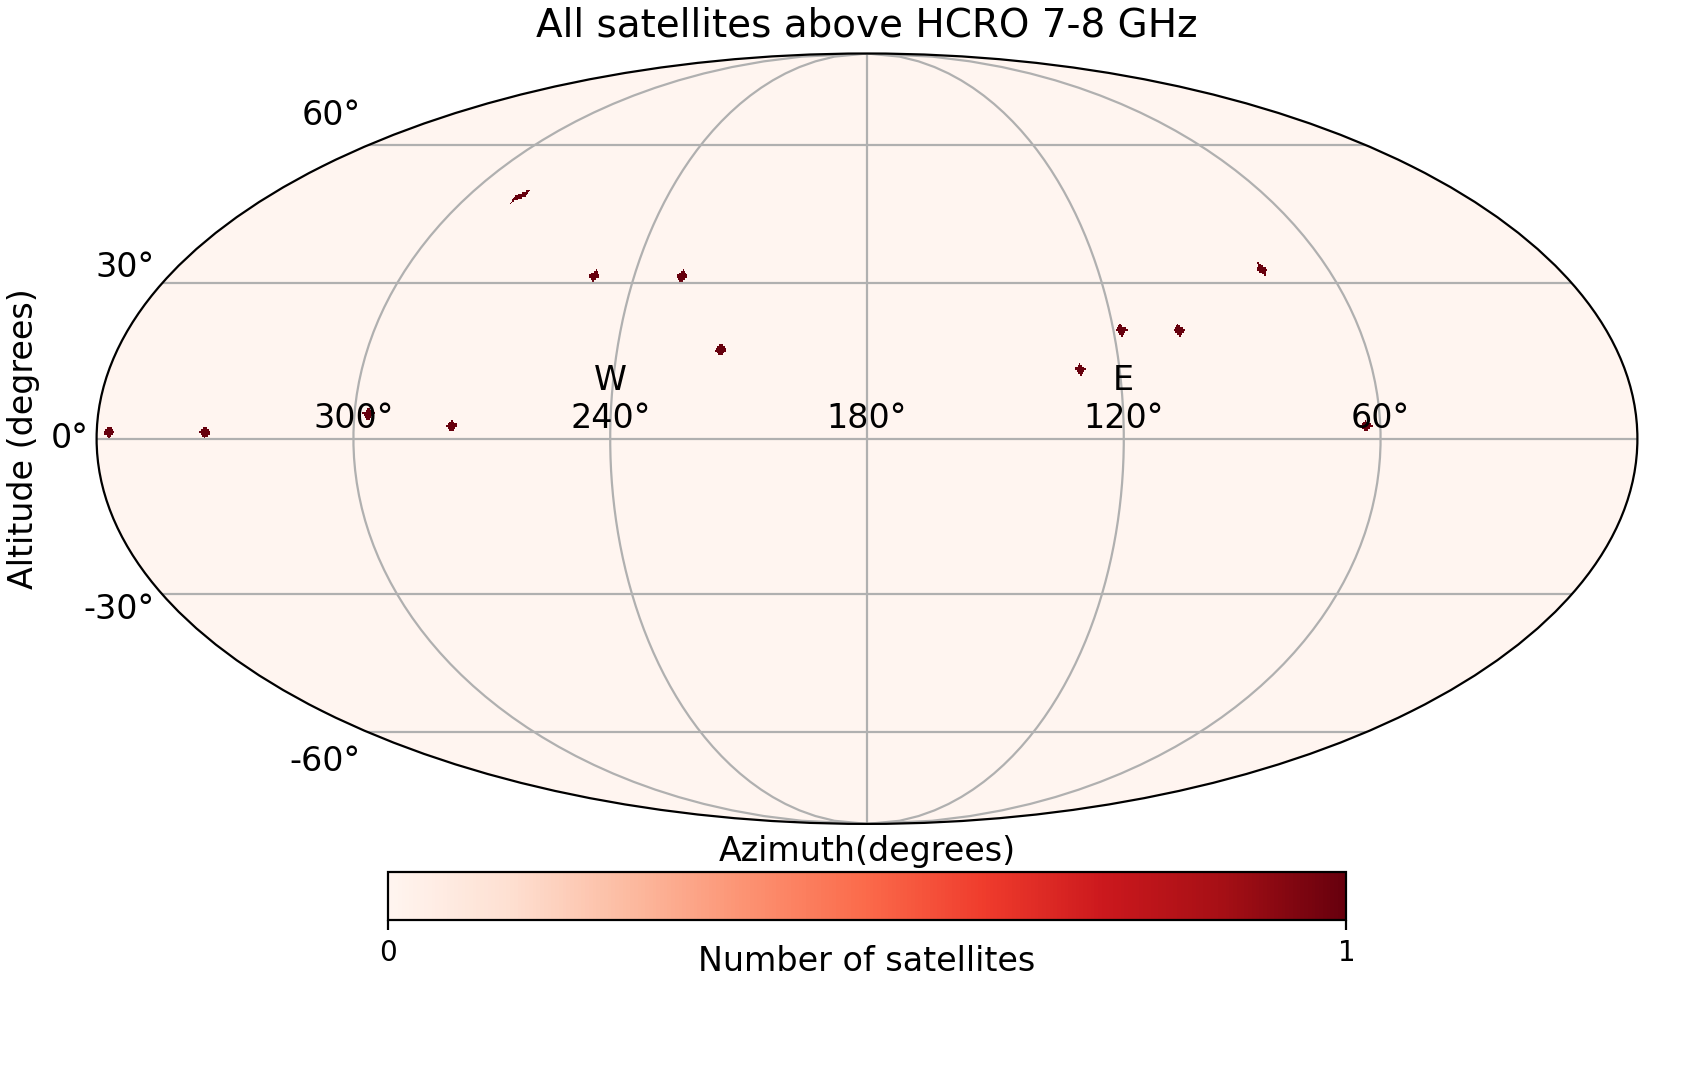

<IPython.core.display.Javascript object>


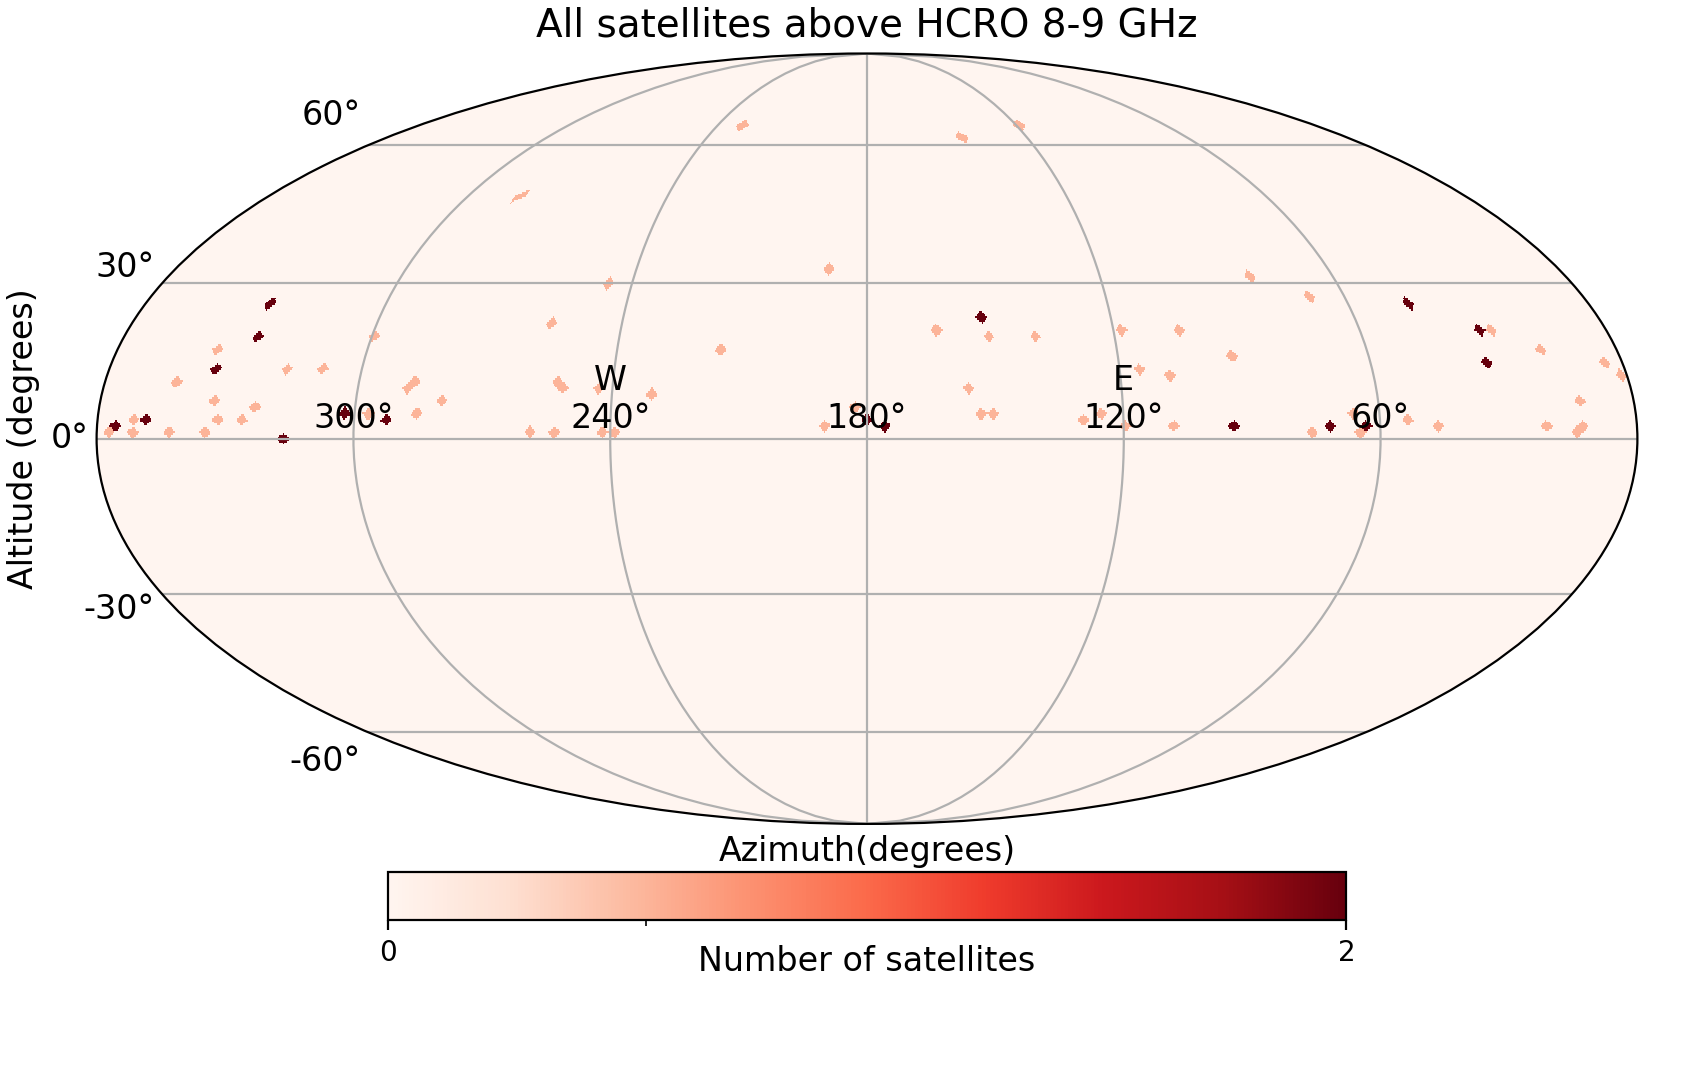

<IPython.core.display.Javascript object>


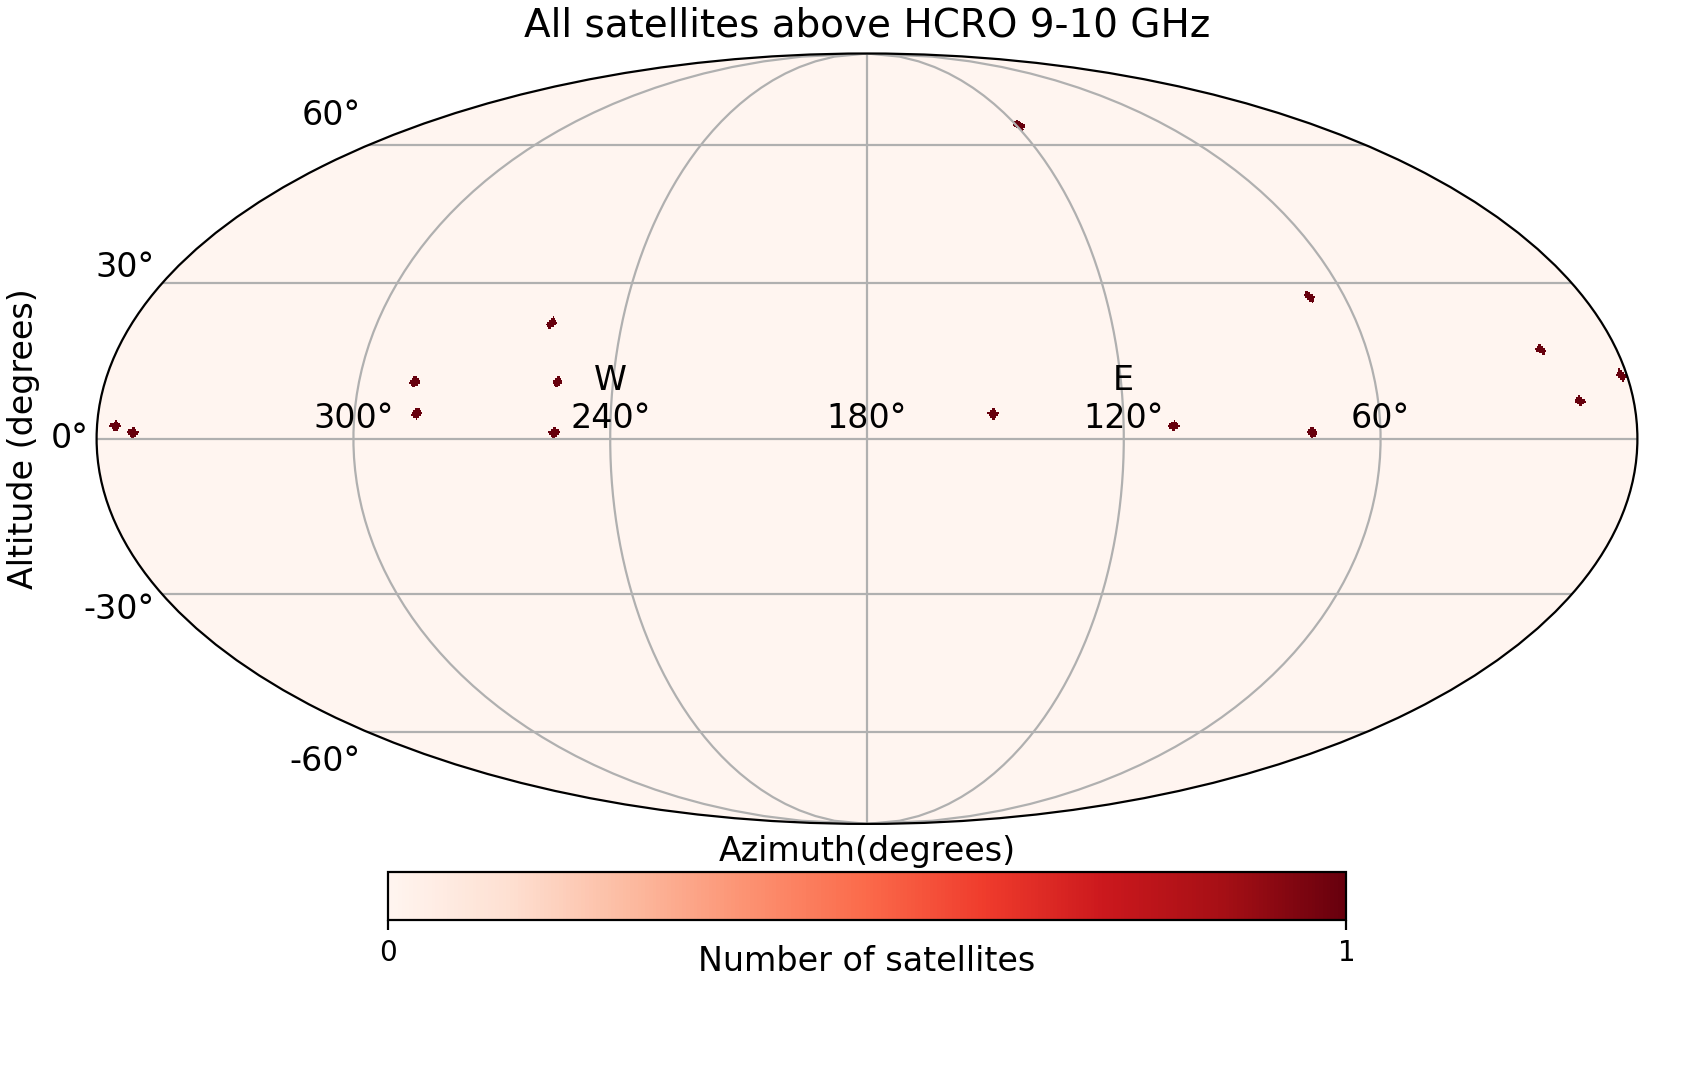

<IPython.core.display.Javascript object>


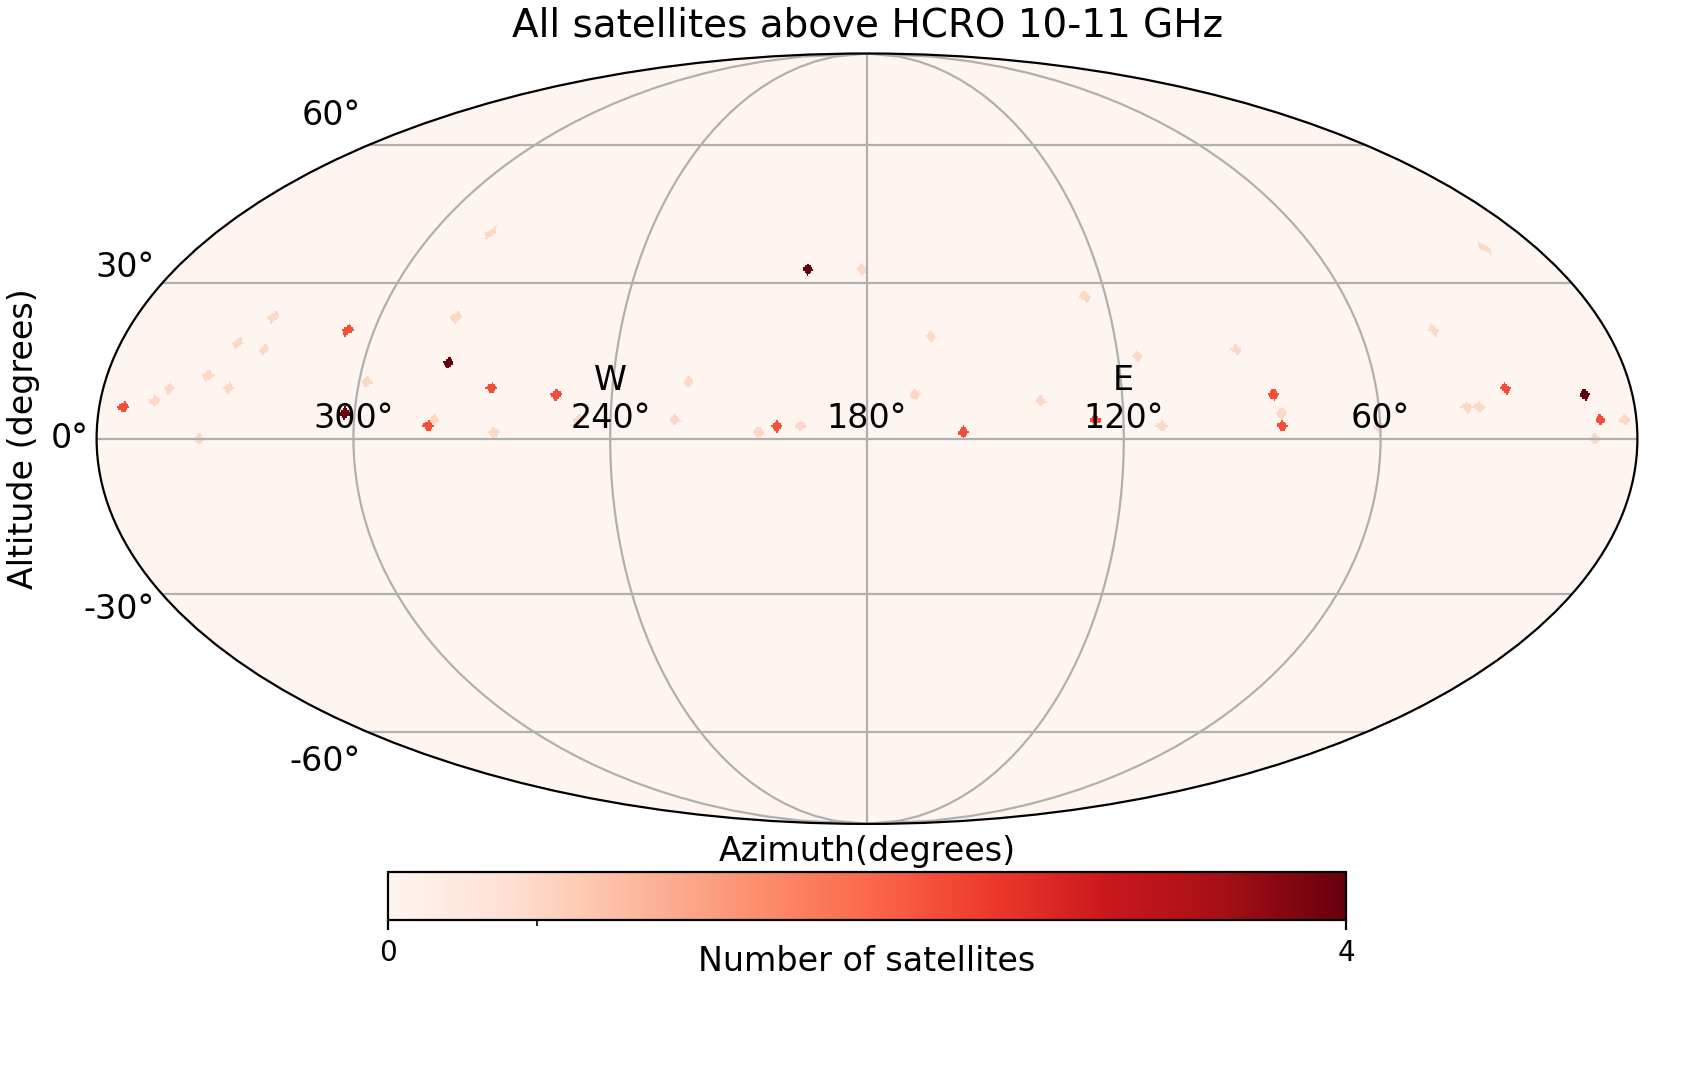

<IPython.core.display.Javascript object>


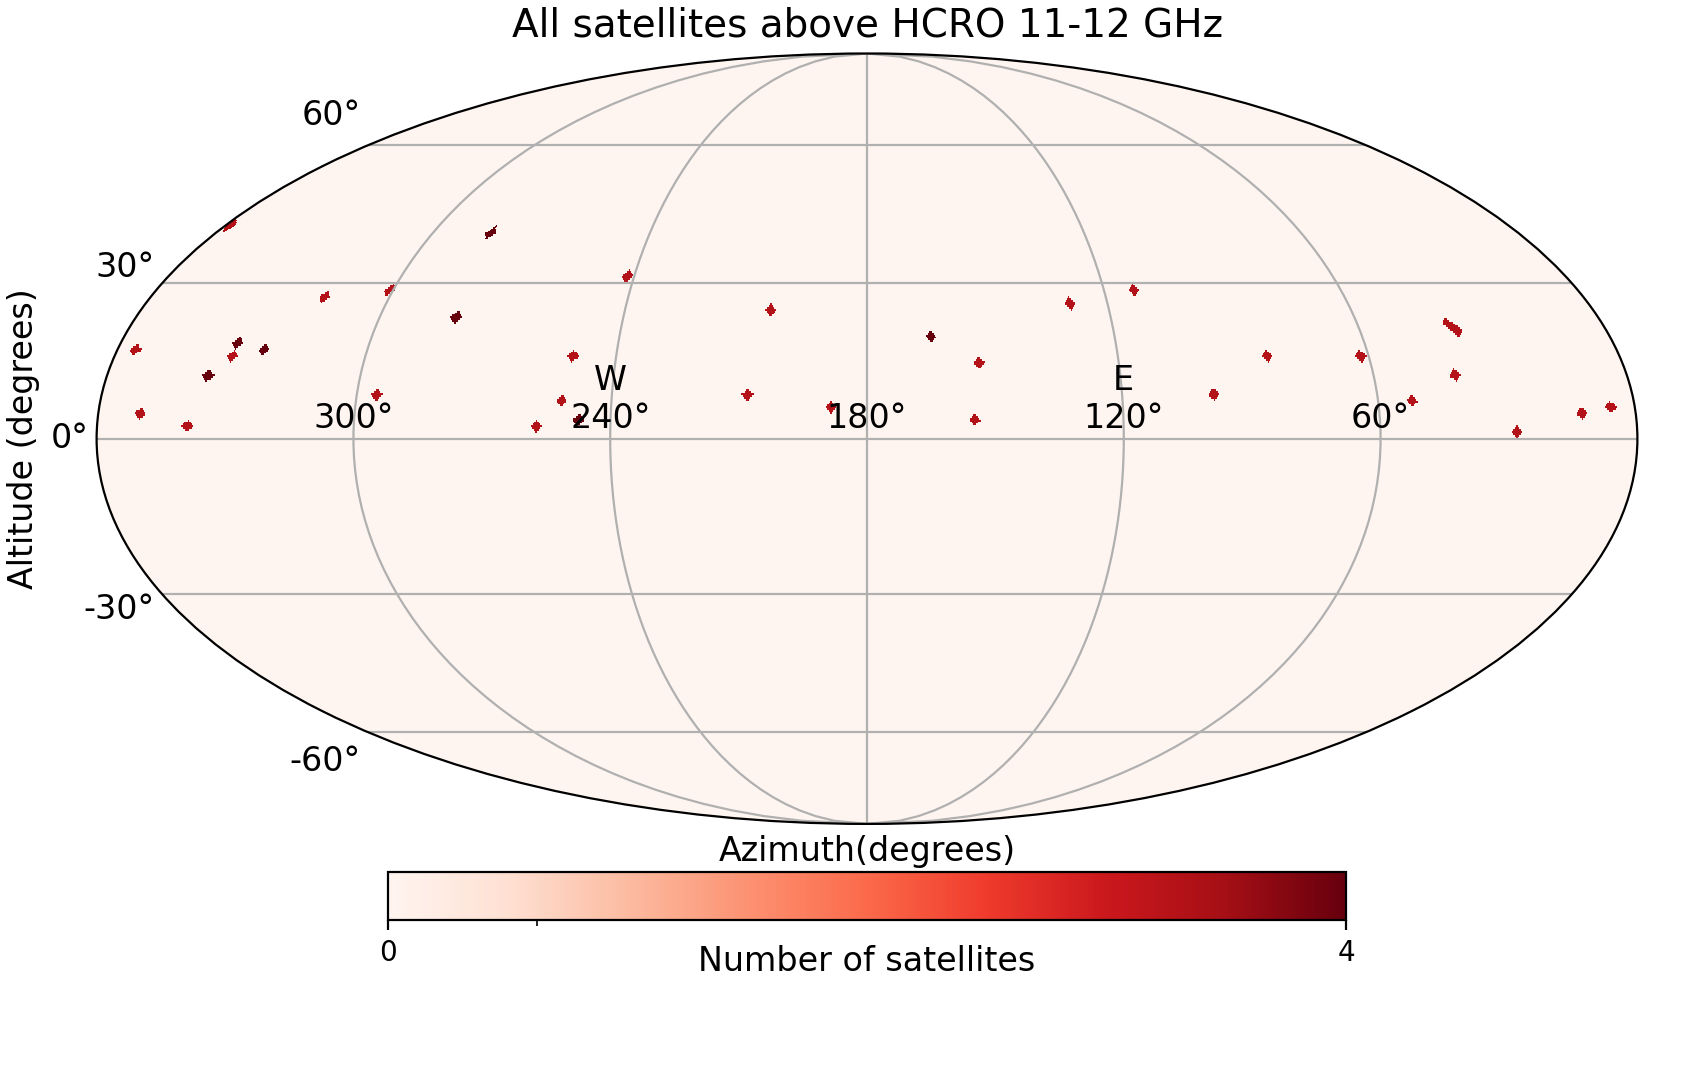

<IPython.core.display.Javascript object>


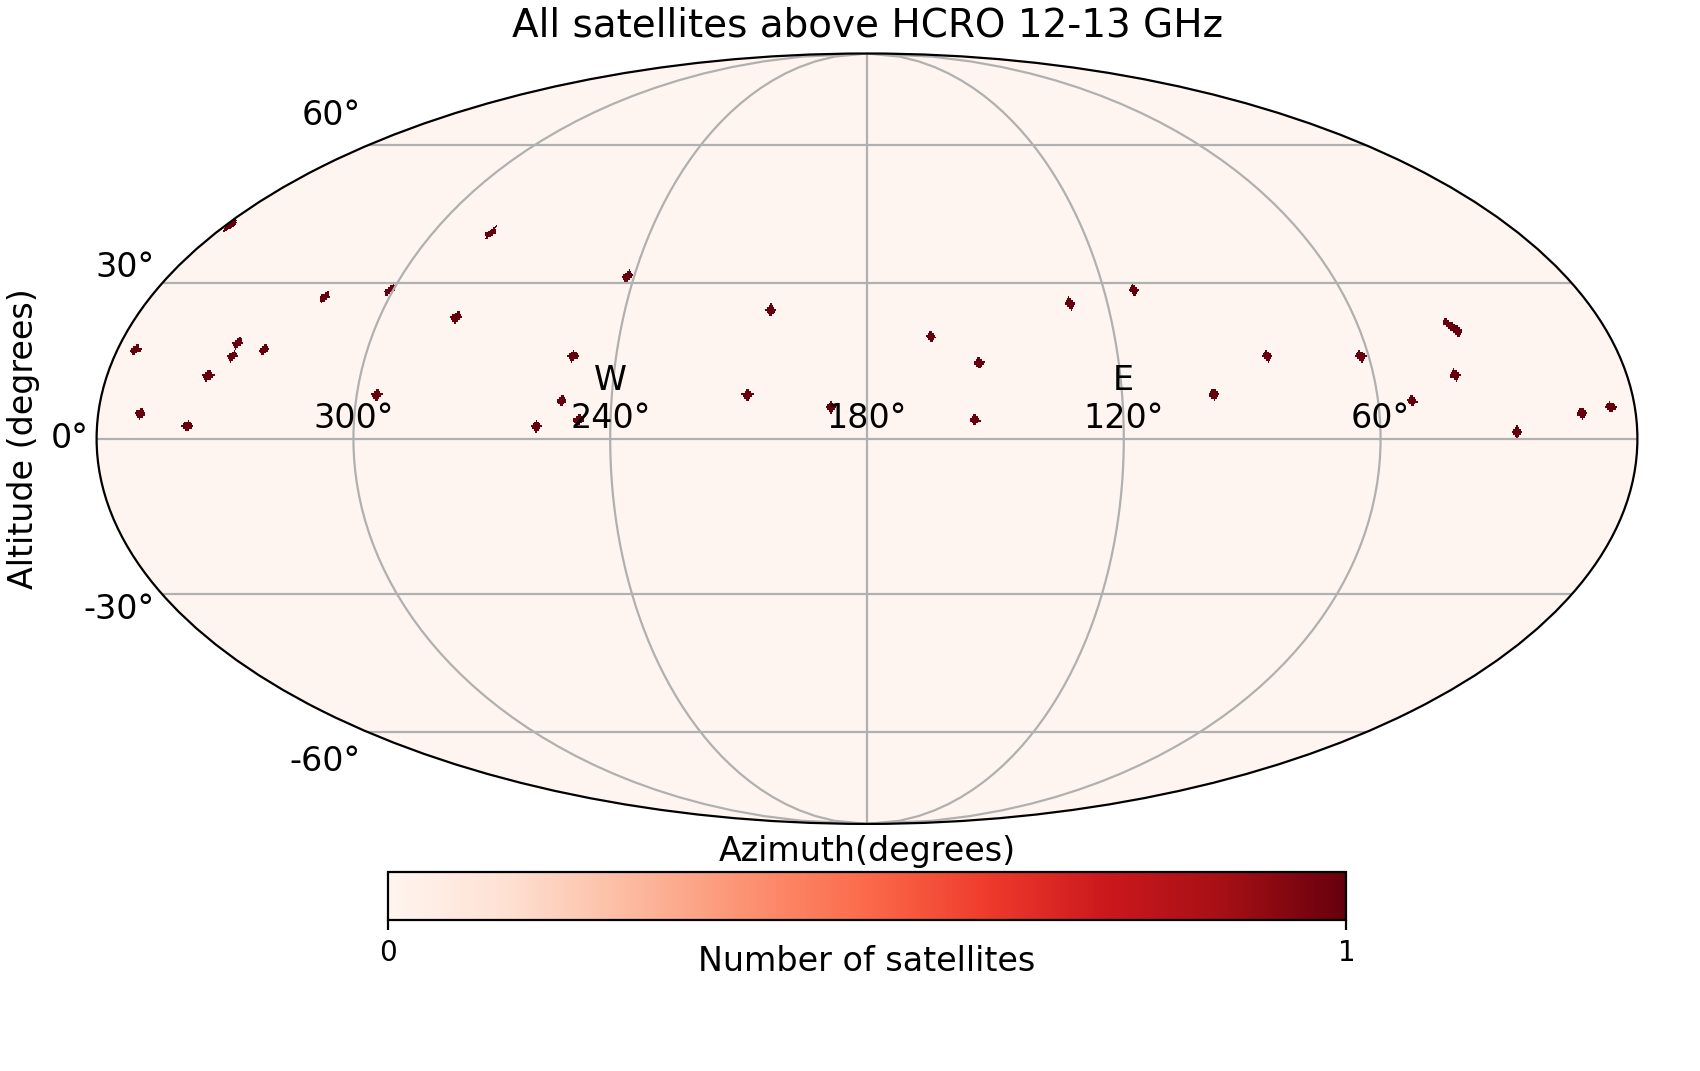

<IPython.core.display.Javascript object>


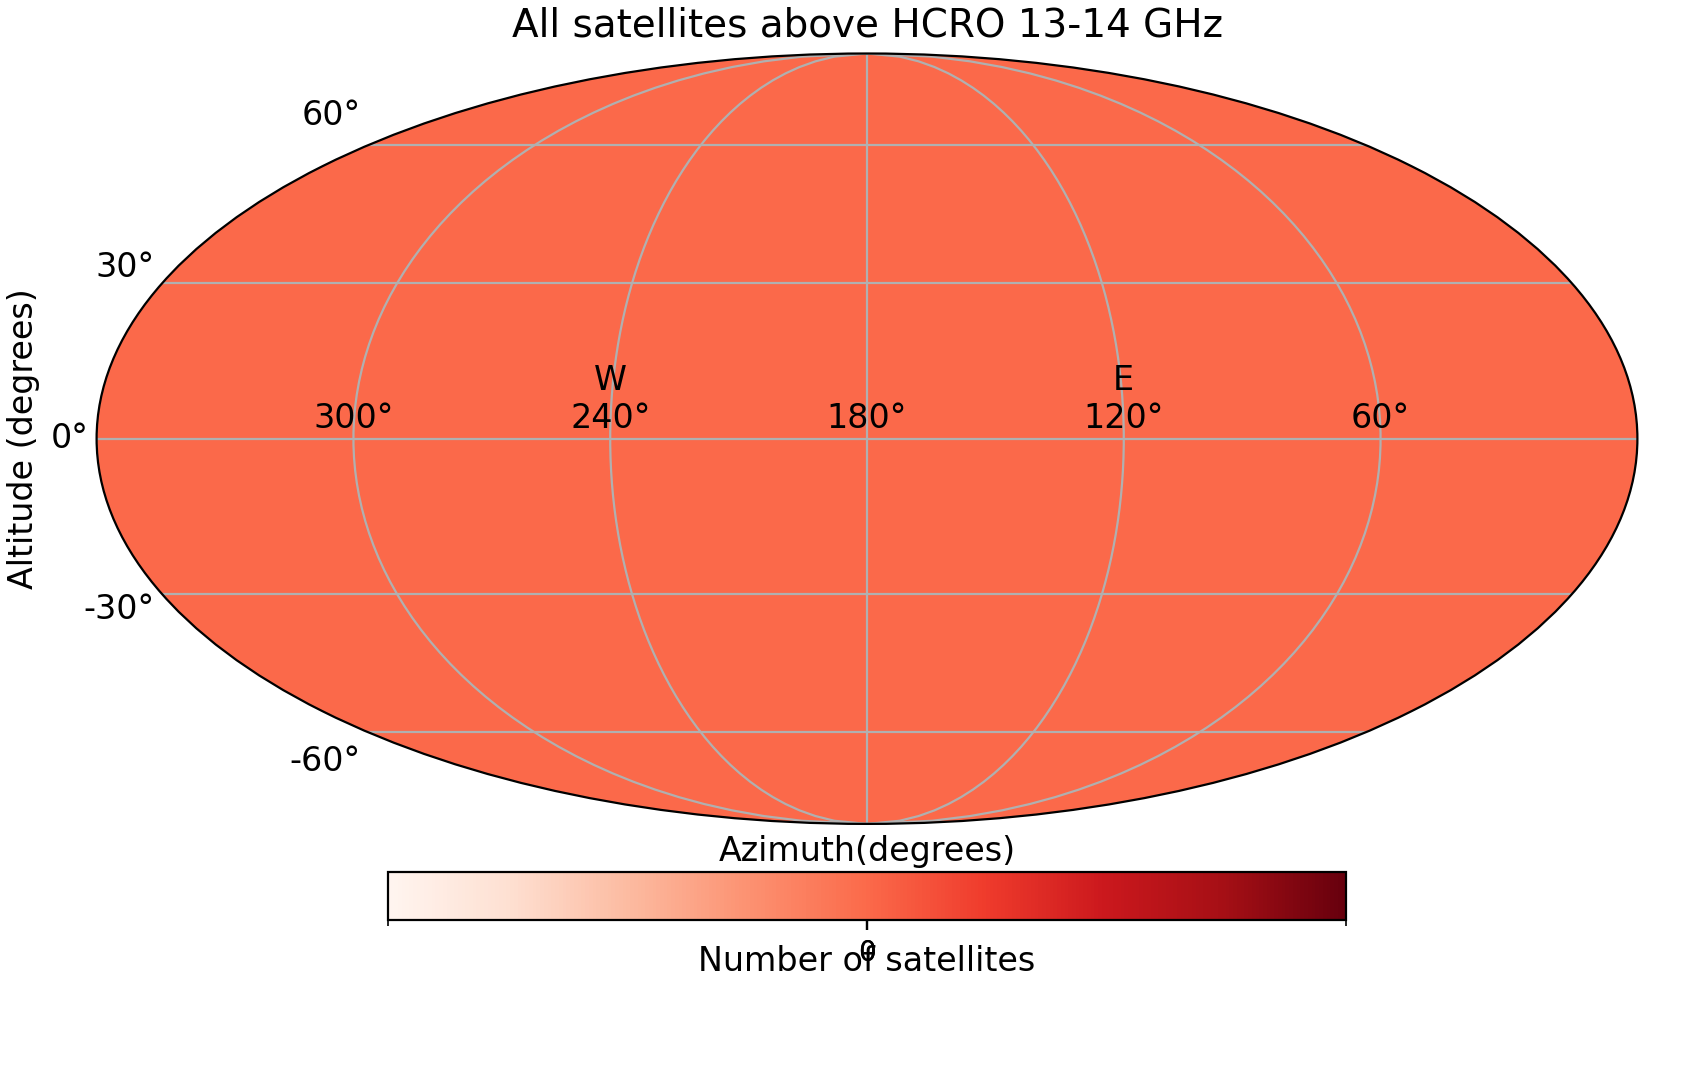

In [66]:
projview(
    m12,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel="Azimuth(degrees)",
    ylabel="Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 1-2 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m23,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 2-3 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog'
);

projview(
    m34,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 3-4 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog'
);

projview(
    m45,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 4-5 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m56,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 5-6 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m67,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 6-7 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m78,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 7-8 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m89,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 8-9 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m910,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 9-10 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m1011,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 10-11 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m1112,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 11-12 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m1213,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 12-13 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);

projview(
    m1314,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 13-14 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', 'W\n240°', '180°', 'E\n120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog',
);


In [45]:
m24 = []
for i in range(len(m23)):
    m24.append(m23[i])
for i in range(len(m34)):
    m24.append(m34[i])

<IPython.core.display.Javascript object>


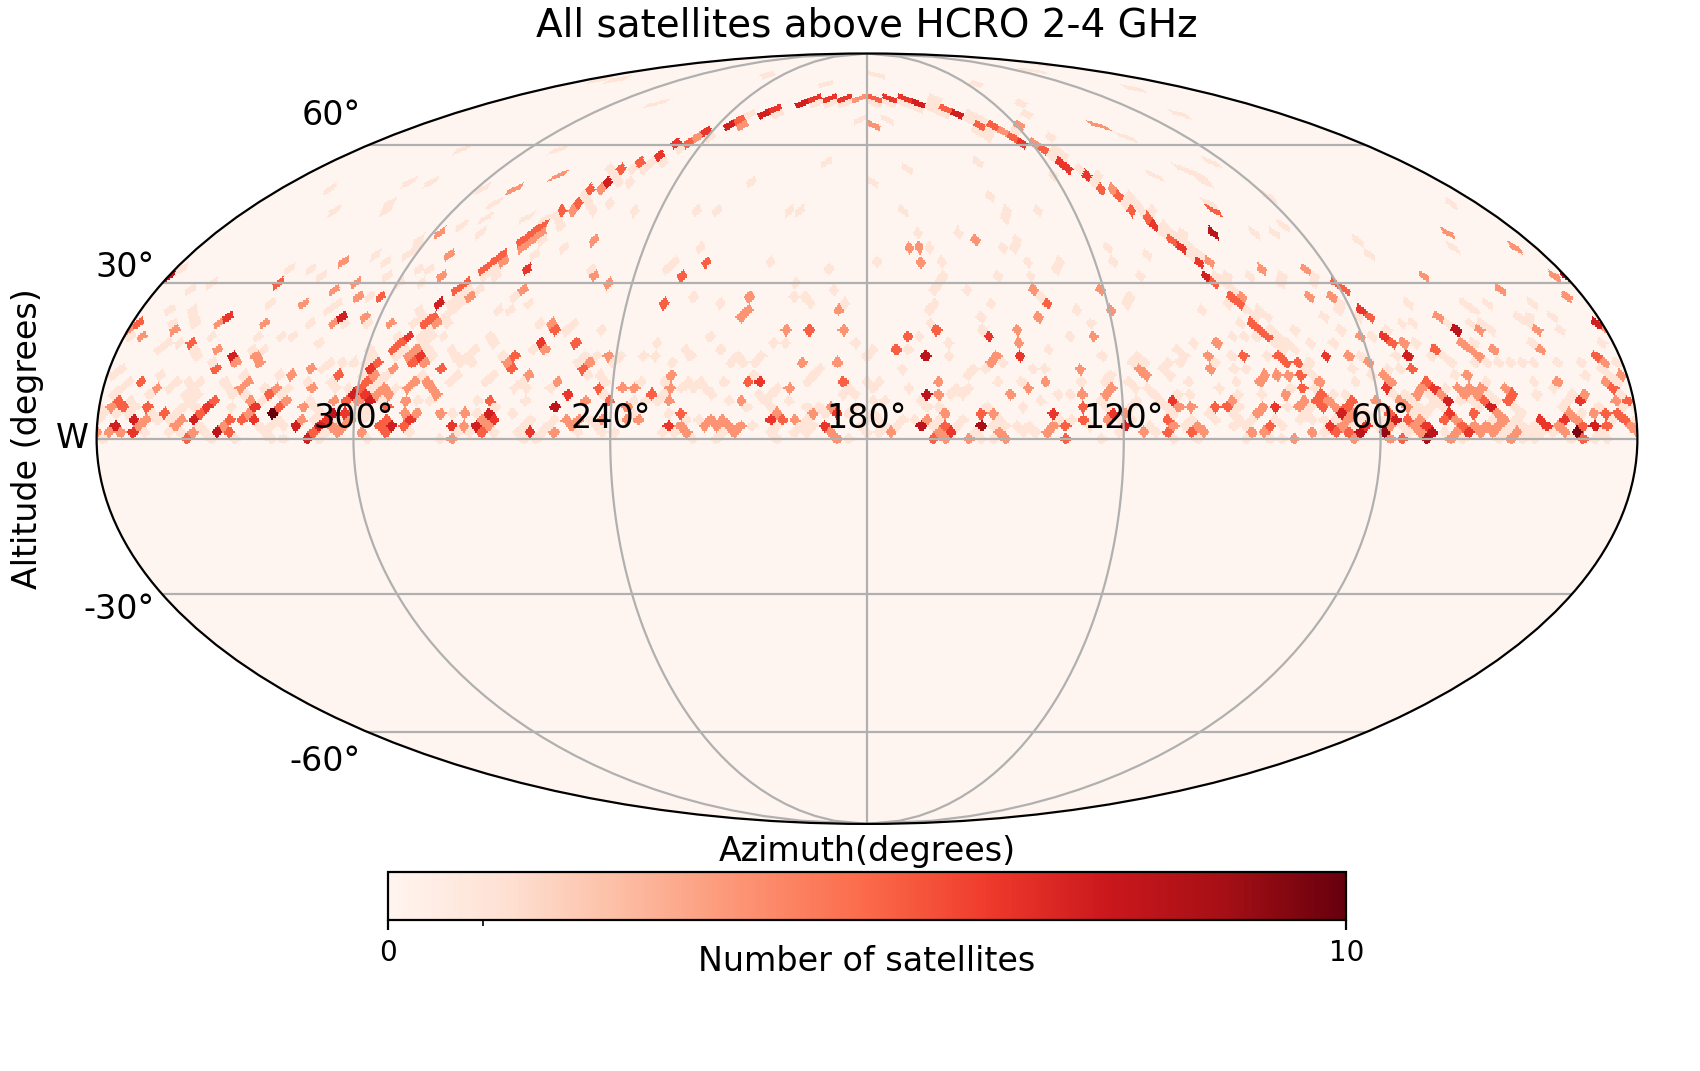

In [46]:
projview(
    m23+m34,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of satellites",
    xlabel = "Azimuth(degrees)",
    ylabel = "Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'All satellites above HCRO 2-4 GHz',
    phi_convention = 'clockwise',
    custom_xtick_labels = ['300°', '240°', '180°', '120°', '60°'],
   # xtick_label_color = 'white',
    custom_ytick_labels = ['-60°', '-30°', 'W', '30°', '60°'],
    norm = 'symlog',
);

In [55]:
dist = []
for i in range(len(distance)):
    dist.append((distance[i] * u.au).to(u.km)/u.km)
    
dist = np.reshape(dist, (len(active), len(t)))#in km

In [56]:
leod = []
meod = []
heod = []
geod = []
for i in range(len(LEO)):
    leod.append(dist[LEO[i]])
    
for i in range(len(MEO)):
    meod.append(dist[MEO[i]])
    
for i in range(len(HEO)):
    heod.append(dist[HEO[i]])
    
for i in range(len(GEO)):
    geod.append(dist[GEO[i]])

In [59]:
ds = []
alts = []
azs = []
for i in range(len(LEO)):
    if namess[LEO[i]][:8] == 'STARLINK':
        ds.append(dist[LEO[i]])
        alts.append(alt[LEO[i]])
        azs.append(az[LEO[i]])

<IPython.core.display.Javascript object>


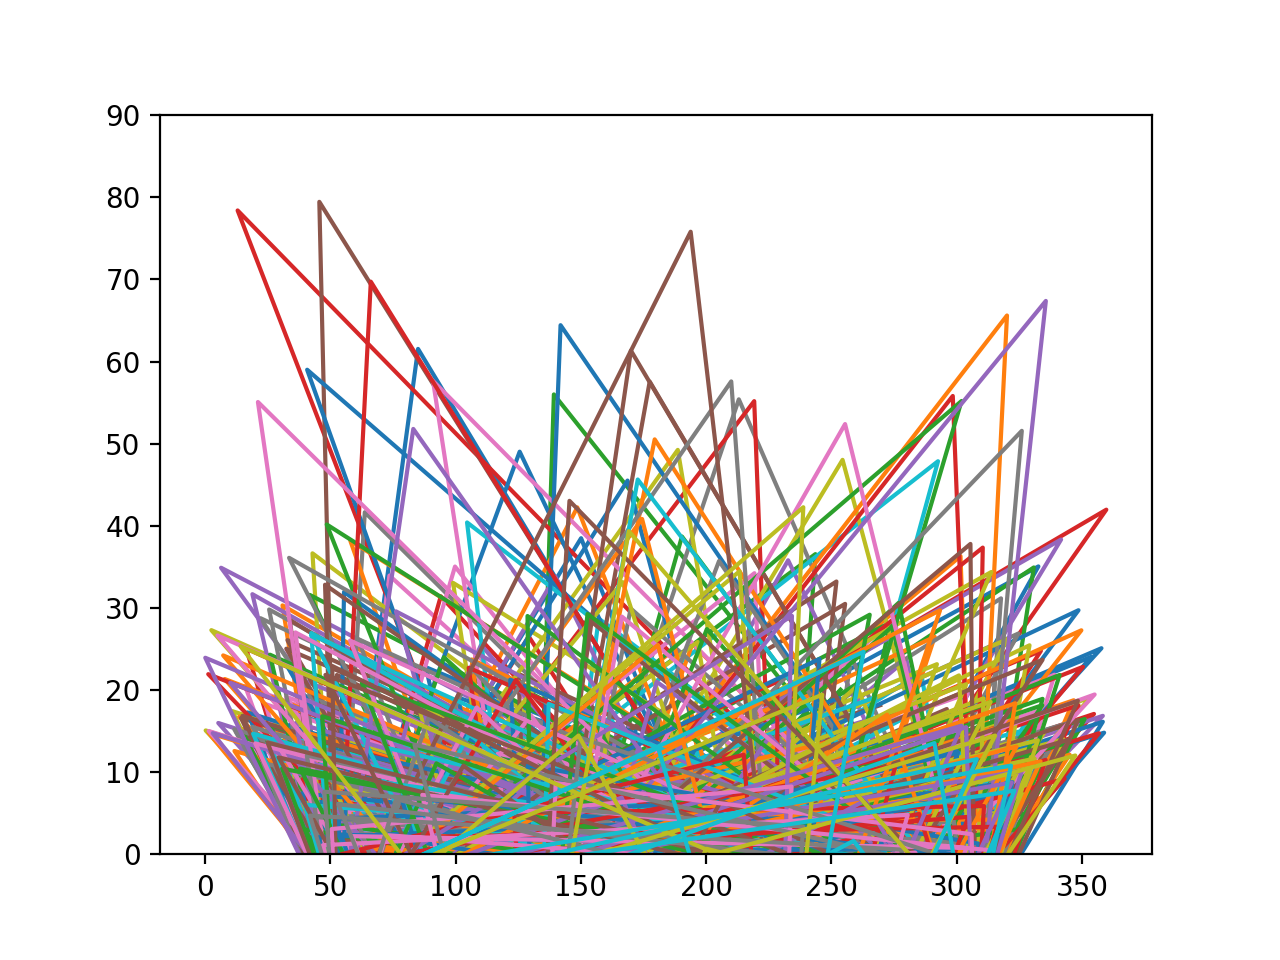

In [60]:
plt.close()
plt.figure()
for i in range(100):
    plt.plot(azs[i], alts[i])
plt.ylim(0, 90)
plt.show()

In [171]:
%%time
LEO_altfs = []
LEO_azfs = []
for j in range(len(LEO)):
    if active[LEO[j]].name[:8] != 'STARLINK':
        for k in range(len(t)):
            if alt[LEO[j]][k] > 0:
                LEO_altfs.append(np.abs(alt[LEO[j]][k] - 90))
                LEO_azfs.append(az[LEO[j]][k])
            elif alt[LEO[j]][k] <= 0:
                LEO_altfs.append(0)
                LEO_azfs.append(0)

CPU times: user 182 ms, sys: 15 ms, total: 197 ms
Wall time: 237 ms


In [176]:
%%time
alt_st = []
az_st = []
distance_st = []
starlink = 0
for i in range(len(LEO)):
    #print(i)
    if namess[LEO[i]][:8] == "STARLINK":
        starlink += 1
        for j in range(len(t)):
        #if alt[LEO[i]]
            alt_st.append(np.abs((difference[LEO[i]].at(tl3[j])).altaz()[0].degrees-90))
            az_st.append((difference[LEO[i]].at(tl3[j])).altaz()[1].degrees)
            distance_st.append((difference[LEO[i]].at(tl3[j])).altaz()[2].au)

CPU times: user 1min 16s, sys: 4.04 s, total: 1min 20s
Wall time: 1min 18s


In [63]:
%%time
GEO_altf = []
GEO_azf = []
HEO_altf = []
HEO_azf = []
MEO_altf = []
MEO_azf = []
LEO_altf = []
LEO_azf = []
testleo = []

for i in range(len(n)):
    #print(i)
    for j in range(len(GEO)):
        if n[i] == GEO[j]:
            for k in range(len(t)):
                if alt[n[i]][k] > 0:
                #if qgeo5r[j][k] != 0:
                    GEO_altf.append(np.abs(alt[n[i]][k] - 90))
                    GEO_azf.append(az[n[i]][k])
                elif alt[n[i]][k] <= 0:
                    GEO_altf.append(0)
                    GEO_azf.append(0)
                    
for i in range(len(n)):
    for j in range(len(MEO)):
        if n[i] == MEO[j]:
            for k in range(len(t)):
                if alt[n[i]][k] > 0:
                #if qmeo5r[j][k] != 0:
                    MEO_altf.append(np.abs(alt[n[i]][k] - 90))
                    MEO_azf.append(az[n[i]][k])
                elif alt[n[i]][k] <= 0:
                    MEO_altf.append(0)
                    MEO_azf.append(0)
                
for i in range(len(n)):
    for j in range(len(HEO)):
        if n[i] == HEO[j]:
            for k in range(len(t)):
                if alt[n[i]][k] > 0:
                #if qheo5r[j][k] != 0:
                    HEO_altf.append(np.abs(alt[n[i]][k] - 90))
                    HEO_azf.append(az[n[i]][k])
                elif alt[n[i]][k] <= 0:
                    HEO_altf.append(0)
                    HEO_azf.append(0)
                
for h in range(len(n)):
    for j in range(len(LEO)):
        if n[h] == LEO[j]:
            for k in range(len(t)):
                if alt[n[h]][k] > 0:
                    testleo.append(n[h])
                    LEO_altf.append(np.abs(alt[n[h]][k] - 90))
                    LEO_azf.append(az[n[h]][k])
                elif alt[n[h]][k] <= 0:
                    LEO_altf.append(0)
                    LEO_azf.append(0)

CPU times: user 1.25 s, sys: 30.5 ms, total: 1.28 s
Wall time: 1.34 s


In [64]:
GEO_altf = np.reshape(GEO_altf, (len(GEO_freq), 144))
GEO_azf = np.reshape(GEO_azf, (len(GEO_freq), 144))

HEO_altf = np.reshape(HEO_altf, (len(HEO_freq), 144))
HEO_azf = np.reshape(HEO_azf, (len(HEO_freq), 144))

MEO_altf = np.reshape(MEO_altf, (len(MEO_freq), 144))
MEO_azf = np.reshape(MEO_azf, (len(MEO_freq), 144))

LEO_altfs = np.reshape(LEO_altfs, (1482, 144))
LEO_azfs = np.reshape(LEO_azfs, (1482, 144))

NameError: name 'LEO_altfs' is not defined

In [ ]:
%%time
altf1012 = []

azf1012 = []
for i in range(len(GEO_altf)):
    for j in range(len(t)):
        if GEO_altf[i][j] != 0:
            if 10.7 <= GEO_freq[i] < (12.7):
                altf1012.append(GEO_altf[i][j])
                azf1012.append(GEO_azf[i][j])
                
for i in range(len(MEO_altf)):
    for j in range(len(t)):
        if MEO_altf[i][j] != 0:
            if 10.7 <= MEO_freq[i] < (12.7):
                altf1012.append(MEO_altf[i][j])
                azf1012.append(MEO_azf[i][j])
                
for i in range(len(HEO_altf)):
    for j in range(len(t)):
        if HEO_altf[i][j] != 0:
            if 10.7 <= HEO_freq[i] < (12.7):
                altf1012.append(HEO_altf[i][j])
                azf1012.append(HEO_azf[i][j])

for i in range(len(LEO_altfs)):
    for j in range(len(t)):
        if LEO_altfs[i][j] != 0:
            if 10.7 <= LEO_freq[i] < (12.7):
                altf1012.append(LEO_altfs[i][j])
                azf1012.append(LEO_azfs[i][j])

for i in range(len(alt_st)):
    altf1012.append(alt_st[i])
    azf1012.append(az_st[i])

In [ ]:
data_as = [np.arange(len(altf1012))]#,np.arange(len(alt_GEOa)), np.arange(len(alt_MEOa)), np.arange(len(alt_LEOa))]
theta_as = [np.radians(altf1012)]#, np.radians(alt_GEOa), np.radians(alt_MEOa), np.radians(alt_LEOa)]
phi_as = [np.radians(azf1012)]#, np.radians(az_GEOa), np.radians(az_MEOa), np.radians(az_LEOa)]


In [ ]:
nside = 2**6

In [ ]:
(hp.nside2resol(nside) * u.rad).to(u.degree)
#Angular resolution of the Mollweide plot

In [ ]:
#Changing the az so we can look due South (so the Mollweide plots show the same shape as the 
#2D plots)
for i in range(len(phi_as[0])):
    if (phi_as[0][i] + np.pi) >= (2*np.pi):
        phi_as[0][i] = phi_as[0][i] - np.pi
    elif (phi_as[0][i] + np.pi) < (2*np.pi):
        phi_as[0][i] = phi_as[0][i] + np.pi

In [ ]:
pixel_indices_as = hp.ang2pix(nside, theta_as[0], phi_as[0])

In [ ]:
pas = hp.ang2pix(nside, theta_as[0], phi_as[0])

In [ ]:
#Correcting for geoa satellites being in the same place
for i in range(len(pixel_indices_as)-1):
    if pas[i] == pas[i+1]:
        pixel_indices_as[i+1] = 0

In [ ]:
mas = np.zeros(hp.nside2npix(nside))

In [ ]:
%%time
#takes about 7 minutes
for i in range(1, len(mas)):
    #print(i)
    for j in range(len(pixel_indices_as)):
        if i == pixel_indices_as[j]:
            mas[i] += 1

In [ ]:
projview(
    mas,
    coord=["G"],
    graticule=True,
    flip = 'astro',
    graticule_labels=True,
    unit="Number of Satellites",
    xlabel="Azimuth (degrees)",
    ylabel="Altitude (degrees)",
    cb_orientation="horizontal",
    projection_type="mollweide",
    cmap = "Reds",
    title = 'GEO satellites above HCRO',
    #phi_convention = 'counterclockwise',
    custom_xtick_labels = ['300°', '240°', '180°', '120°', '60°'],
    custom_ytick_labels = ['-60°', '-30°', '0°', '30°', '60°'],
    norm = 'symlog'
);
#plt.savefig('GEO_m.png')